In [1]:
#Library Import
import zipfile
import os
import torch
import numpy as np
import cv2
import pandas as pd
from torch import nn
from torch.optim import AdamW
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from transformers import (
    ViTImageProcessor, ViTForImageClassification,
    AutoImageProcessor, SwinForImageClassification,
    BeitImageProcessor, BeitForImageClassification
)
import torchvision.models as models
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score, roc_auc_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from IPython.display import display
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from itertools import product
import time
from PIL import Image
from torchinfo import summary
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Setup and Preprocessing: CIFAKE

This section handles the complete preparation of the CIFAKE dataset, which includes both real and AI-generated images (labeled `REAL` and `FAKE`, respectively). The goal is to consolidate the dataset, structure it into a usable format, and split it for training, validation, and testing in a way that supports robust model development and evaluation.

### Dataset Source and Structure

- The dataset is stored locally in the following directory:

  ```
  C:/Users/Alberto/Desktop/TCD/DISSERTATION/Code and dataset/CIFAKE
  ```

- It contains the following subdirectories:
  ```
  CIFAKE/
    └── train/
         ├── FAKE/
         └── REAL/
    └── test/
         ├── FAKE/
         └── REAL/
  ```

Although the dataset was initially split into `train` and `test`, we ignore this predefined structure and rebuild a **combined dataset** to ensure a consistent and reproducible stratified split into training, validation, and test sets.


### Step-by-Step Process

1. **Build a Combined Dataset**  
   - Both `train/` and `test/` subfolders are scanned.
   - For each image, the full file path and its class label (`FAKE` or `REAL`) are collected.
   - All records are stored in a unified dataframe with the following structure:
     - `image`: full path to the image file
     - `label`: class label as a string

2. **Initial Dataset Sanity Check**  
   - The total number of samples is printed.
   - Label distribution is shown to verify that the dataset is balanced across both classes.

3. **Stratified Train/Validation/Test Split (70/15/15)**  
   - The dataset is split using `sklearn.model_selection.train_test_split`:
     - **First split**: 70% for training and 30% for temporary use (to be split further).
     - **Second split**: the temporary 30% is divided equally into 15% validation and 15% test sets.
   - All splits are **stratified** to ensure that the proportion of FAKE and REAL images is preserved in each subset.

4. **Split Summary and Validation**  
   - The number of samples in each subset (train, validation, test) is printed.
   - Class distributions are checked and displayed for each subset to confirm class balance.

In [2]:
# Run this cell only the first time to extract the CIFAKE dataset from the zip file.
# Make sure to adjust the paths according to your system.


'''
# Define the path to the zip file and the extraction directory

zip_path = "C:/Users/Alberto/Desktop/TCD/DISSERTATION/Code and dataset/CIFAKE.zip"
# Define the extraction path
# You can change this to any directory you prefer
extract_path = "C:/Users/Alberto/Desktop/TCD/DISSERTATION/Code and dataset/CIFAKE" 

# Make sure the path exists
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("CIFAKE extracted to:", extract_path)

for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:  # Only show first 5 files
        print(f"{subindent}{f}")
'''


'\n# Define the path to the zip file and the extraction directory\n\nzip_path = "C:/Users/Alberto/Desktop/TCD/DISSERTATION/Code and dataset/CIFAKE.zip"\n# Define the extraction path\n# You can change this to any directory you prefer\nextract_path = "C:/Users/Alberto/Desktop/TCD/DISSERTATION/Code and dataset/CIFAKE" \n\n# Make sure the path exists\nos.makedirs(extract_path, exist_ok=True)\n\n# Extract\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n\nprint("CIFAKE extracted to:", extract_path)\n\nfor root, dirs, files in os.walk(extract_path):\n    level = root.replace(extract_path, \'\').count(os.sep)\n    indent = \' \' * 2 * level\n    print(f"{indent}{os.path.basename(root)}/")\n    subindent = \' \' * 2 * (level + 1)\n    for f in files[:5]:  # Only show first 5 files\n        print(f"{subindent}{f}")\n'

In [2]:
extract_path = "C:/Users/Alberto/Desktop/TCD/DISSERTATION/Code and dataset/CIFAKE"
# Set the path to the extracted dataset
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')

# Build combined DataFrame directly
data = []
for base_dir in [train_dir, test_dir]:
    for label in ['FAKE', 'REAL']:
        label_dir = os.path.join(base_dir, label)
        for fname in os.listdir(label_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(label_dir, fname)
                data.append((full_path, label))

combined_df = pd.DataFrame(data, columns=['image', 'label'])

# Preview
print("Combined dataset:", combined_df.shape)
print("\nLabel distribution:")
print(combined_df['label'].value_counts())

# Split into 70/15/15 (train/val/test)
# First split: 70% train, 30% temp (which will be split into 15% val + 15% test)
train_df, temp_df = train_test_split(
    combined_df,
    test_size=0.3,
    random_state=42,
    stratify=combined_df['label']
)

# Second split: 15% val, 15% test (50/50 split of the 30% temp)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)} ({len(train_df)/len(combined_df)*100:.1f}%)")
print(f"Val: {len(val_df)} ({len(val_df)/len(combined_df)*100:.1f}%)")
print(f"Test: {len(test_df)} ({len(test_df)/len(combined_df)*100:.1f}%)")

print(f"\nTrain label distribution:")
print(train_df['label'].value_counts())
print(f"\nVal label distribution:")
print(val_df['label'].value_counts())
print(f"\nTest label distribution:")
print(test_df['label'].value_counts())

Combined dataset: (120000, 2)

Label distribution:
label
FAKE    60000
REAL    60000
Name: count, dtype: int64

Split sizes:
Train: 84000 (70.0%)
Val: 18000 (15.0%)
Test: 18000 (15.0%)

Train label distribution:
label
FAKE    42000
REAL    42000
Name: count, dtype: int64

Val label distribution:
label
FAKE    9000
REAL    9000
Name: count, dtype: int64

Test label distribution:
label
FAKE    9000
REAL    9000
Name: count, dtype: int64


### Model and Processor Loader with Dropout Regularization

This function, `load_model_and_processor()`, dynamically loads a pre-trained Vision Transformer-based model and its corresponding image processor from the Hugging Face Transformers library. It supports the following architectures:

- **ViT**: `vit-base-patch16-224`
- **Swin Transformer**: `swin-base-patch4-window7-224`
- **BEiT**: `beit-base-patch16-224`

#### Key Features:

- **Dynamic model selection**: The function accepts a `model_type` argument (`"vit"`, `"swin"`, or `"beit"`) and loads the corresponding model and processor.
- **Classification head customization**: 
  - The original classifier layer is replaced with a new `Sequential` head that includes a `Dropout(p=0.2)` layer followed by a linear layer.
  - This helps reduce overfitting, especially when fine-tuning on a small dataset like CIFAKE.
- **Ignore mismatched sizes**: The argument `ignore_mismatched_sizes=True` allows resizing of the classification head if the original number of output classes differs from the target.
- **Verbose feedback**: Prints confirmation of model loading and output configuration to ensure transparency during experimentation.

#### Output:

The function returns:
- `model`: a PyTorch model ready for fine-tuning or inference
- `processor`: the corresponding image processor for pre-processing inputs (e.g., resizing, normalization)

This modular design supports flexible experimentation with different backbone architectures while maintaining a consistent interface for downstream training and evaluation.


In [3]:
def load_model_and_processor(model_type: str, num_labels: int, unfreeze_blocks: int = 2):
    model_type = model_type.lower()

    if model_type == "vit":
        model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

    elif model_type == "swin":
        model = SwinForImageClassification.from_pretrained(
            "microsoft/swin-base-patch4-window7-224",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224", use_fast=True)

    elif model_type == "beit":
        model = BeitForImageClassification.from_pretrained(
            "microsoft/beit-base-patch16-224",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        processor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")

    elif model_type == "resnet50":
        model = models.resnet50(pretrained=True)
        processor = None
        hidden_size = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, num_labels)
        )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Step 1: Freeze ALL layers
    for param in model.parameters():
        param.requires_grad = False

    # Step 2: Unfreeze classifier
    if hasattr(model, 'classifier'):
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif hasattr(model, 'fc'):
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        raise AttributeError(f"Model {model_type} has neither 'classifier' nor 'fc'.")

    # Step 3: Unfreeze LAST N BLOCKS
    encoder_layers = []

    if model_type == 'vit':
        encoder_layers = model.vit.encoder.layer
    elif model_type == 'beit':
        encoder_layers = model.beit.encoder.layer
    elif model_type == 'swin':
        encoder_layers = []
        try:
            for stage in model.swin.encoder.layers:
                encoder_layers.extend(stage.blocks)
        except AttributeError:
            raise ValueError("Could not access encoder blocks for Swin model.")
    elif model_type == 'resnet50':
        # ResNet50 has 4 main blocks: layer1, layer2, layer3, layer4
        block_map = [model.layer1, model.layer2, model.layer3, model.layer4]
        encoder_layers = block_map[-unfreeze_blocks:]  # last N blocks

    # Unfreeze selected layers
    if encoder_layers:
        if model_type == 'resnet50':
            # For ResNet, we're working with sequential blocks
            for block in encoder_layers:
                for param in block.parameters():
                    param.requires_grad = True
        else:
            # For transformer models (ViT, BEIT, Swin)
            total = len(encoder_layers)
            layers_to_unfreeze = encoder_layers[-unfreeze_blocks:] if unfreeze_blocks <= total else encoder_layers
            
            for layer in layers_to_unfreeze:
                for param in layer.parameters():
                    param.requires_grad = True
        
        print(f"Unfroze last {min(unfreeze_blocks, len(encoder_layers))} block(s) out of {len(encoder_layers)} for {model_type.upper()}")
    else:
        print(f"Warning: No encoder layers found for {model_type.upper()}")

    print(f"Loaded {model_type.upper()} with {num_labels} output classes")
    return model, processor

## Custom Dataset Class for Training and Evaluation
This section defines a custom PyTorch Dataset called TrainingImageDataset, which interfaces with the DataFrame of image paths and labels.

### **Main responsibilities**:

* Converts image paths into RGB images using PIL.

* Applies preprocessing using the associated Hugging Face image processor (ViT, Swin, or BEiT).

* Returns a processed tensor and corresponding label for each sample.

Using a standardized dataset class improves compatibility across models and enables efficient batching via DataLoader.

In [4]:
transformer_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

In [5]:
resnet_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

resnet_val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
class TrainingImageDataset(Dataset):
    def __init__(self, dataframe, processor=None, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.processor = processor
        self.transform = transform
        self.label_map = {'FAKE': 0, 'REAL': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image']
        label_str = self.dataframe.iloc[idx]['label']
        image = Image.open(image_path).convert("RGB")
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)  # image is a tensor

        if self.processor:
            processed = self.processor(images=image, return_tensors="pt")
            pixel_values = processed['pixel_values'].squeeze()
            return {'pixel_values': pixel_values, 'labels': label}
        else:
            return image, label  # Required format for PyTorch training loop


# Fine-Tuning Hyperparameters


## Step 1: Creating Balanced Subsets for Hyperparameter Tuning

To accelerate the hyperparameter tuning process, we generate smaller subsets from the original training and validation datasets. This enables faster experimentation without compromising the representativeness of the data.

The `create_subset_dataframes()` function achieves this by:

* Taking a user-defined fraction of the original datasets (default: 5%),

* Applying stratified sampling to preserve the class distribution across subsets,

* Using a fixed `random_state` for reproducibility,

* Returning two reduced DataFrames, `train_subset` and `val_subset`, which maintain the label balance of the original data.

Stratified sampling is particularly important here to ensure that rare classes are still adequately represented during hyperparameter optimization. This avoids introducing bias or instability into the learning process.

This step is crucial for efficient development, allowing the use of a small yet balanced dataset for rapid iteration during the tuning phase.

In [8]:
def create_subset_dataframes(train_df, val_df, subset_size=0.05):
    """
    Create smaller subsets for hyperparameter tuning.

    Args:
        train_df: Training dataframe
        val_df: Validation dataframe
        subset_size: Fraction of data to use (0.05 = 5%)

    Returns:
        train_subset, val_subset: Smaller dataframes maintaining label balance
    """

    train_subset, _ = train_test_split(
            train_df,
            test_size=1 - subset_size,
            stratify=train_df["label"],
            random_state=42
        )

    val_subset, _ = train_test_split(
            val_df,
            test_size=1 - subset_size,
            stratify=val_df["label"],
            random_state=42
        )

    print(f"Original train size: {len(train_df)} -> Subset: {len(train_subset)}")
    print(f"Original val size: {len(val_df)} -> Subset: {len(val_subset)}")
    print(f"Train subset label distribution:\n{train_subset['label'].value_counts()}")
    print(f"Val subset label distribution:\n{val_subset['label'].value_counts()}")

    return train_subset, val_subset

## Step 2: Defining Evaluation Metrics

To assess the **model's performance** during validation and testing, we define a custom `compute_metrics()` function. This function is compatible with Hugging Face’s `Trainer` API and is invoked automatically at the end of each evaluation phase.

The function computes four key classification metrics:

* **Accuracy**: The overall proportion of correctly predicted samples.

* **Precision**: The weighted average of precision scores across classes, measuring how many of the predicted positives are actually correct.

* **Recall**: The weighted average recall, indicating how many actual positives are correctly identified.

* **F1-Score**: The harmonic mean of precision and recall, providing a balanced measure that accounts for both false positives and false negatives.

Internally, the predicted logits are first converted into discrete class labels using `argmax`, and all metrics are computed using scikit-learn's evaluation utilities. A `'weighted'` averaging strategy is adopted to account for potential class imbalance, ensuring that the contribution of each class is proportional to its support in the dataset.

These metrics provide a comprehensive understanding of the model's classification behaviour, particularly in tasks involving imbalanced or multi-class datasets.

In [7]:
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, F1 for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Step 3: Hyperparameter Search with Early Stopping
To optimize the model's performance, we implement a custom hyperparameter search routine. The `hyperparameter_search()` function systematically evaluates various combinations of training configurations using a grid search strategy, tailored to the selected Transformer model (e.g., ViT, Swin, BEiT).

### Key Features of This Implementation:
* **Parameter Grid**: We define a grid over several influential hyperparameters:

    * **learning_rate**: Step size for model updates

    * **batch_size**: Number of samples per gradient update

    * **warmup_ratio**: Proportion of training steps used for warm-up

    * **weight_decay**: Regularization to prevent overfitting

    * **patience**: Number of epochs without improvement before early stopping

    * **epochs**: Maximum training epochs

* **Dataset Preprocessing**: A subset of the original training and validation data is converted into custom PyTorch datasets using a Hugging Face-compatible `processor`.

* **Training and Evaluation Loop**:

    * For each parameter combination, a fresh instance of the model is loaded.

    * Training is executed using the Hugging Face `Trainer` API, with an `EarlyStoppingCallback` based on the F1 score.

    * Evaluation is performed at the end of each epoch, and metrics are computed using a custom `compute_metrics()` function.

    * Results, including F1, accuracy, precision, recall, and training time, are recorded.

* **Model Selection**:

    * The model yielding the highest weighted F1 score is identified as the best-performing configuration.

    * The function returns a summary DataFrame of all results and the best parameter set for downstream training.

    * This design balances exploration breadth with computational efficiency and ensures robustness by catching exceptions during training. It also enforces reproducibility through deterministic randomness and standardized evaluation metrics.

In [10]:
def hyperparameter_search(model_type, train_subset, val_subset, processor, device='cuda'):

    # Define hyperparameter grid
    param_grid = {
        'learning_rate': [2e-4, 2e-5],
        'batch_size': [8, 16],
        'warmup_ratio': [0.1],
        'weight_decay': [0.01],
        'patience': [2],
        'epochs': [3, 5]  # Reduced epochs for faster tuning,
    }
    print(f"Testing {len(list(product(*param_grid.values())))} combinations...")

    results = []
    best_f1 = 0
    best_params = None

    # Create datasets once
    train_dataset = TrainingImageDataset(train_subset, processor)
    val_dataset = TrainingImageDataset(val_subset, processor)

    for i, params in enumerate(product(*param_grid.values())):
        lr, batch_size, warmup_ratio, weight_decay, patience, max_epochs = params

        print(f"\n--- Experiment {i+1} ---")
        print(f"LR: {lr}, Batch: {batch_size}, Warmup: {warmup_ratio}, WD: {weight_decay}, Patience: {patience}, Epochs: {max_epochs}")

        try:
            # Load fresh model for each experiment
            model, _ = load_model_and_processor(model_type, num_labels=2)
            model.to(device)

            # Training arguments
            training_args = TrainingArguments(
                output_dir=f'./temp_checkpoints_{model_type}_{i}',
                num_train_epochs=max_epochs,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                learning_rate=lr,
                weight_decay=weight_decay,
                warmup_ratio=warmup_ratio,
                logging_steps=50,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                report_to= "none",  # Disable wandb/tensorboard
                save_total_limit=1,  # Only keep best checkpoint
            )

            # Create trainer with early stopping callback
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
            )


            # Train and evaluate
            start_time = time.time()
            trainer.train()
            eval_results = trainer.evaluate()
            training_time = time.time() - start_time


            print(f"Training completed successfully")
            print(f"Eval results keys: {eval_results.keys()}")
            # Store results
            result = {
                'experiment': i+1,
                'model_type': model_type,
                'learning_rate': lr,
                'batch_size': batch_size,
                'warmup_ratio': warmup_ratio,
                'weight_decay': weight_decay,
                'patience': patience,
                'epochs': max_epochs,
                'accuracy': eval_results['eval_accuracy'],
                'f1': eval_results['eval_f1'],
                'precision': eval_results['eval_precision'],
                'recall': eval_results['eval_recall'],
                'training_time': training_time
            }
            results.append(result)

            # Track best model - only if we have valid F1 score
            current_f1 = eval_results.get('eval_f1', 0.0)
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'warmup_ratio': warmup_ratio,
                    'weight_decay': weight_decay,
                    'patience': patience,
                    'max_epochs': max_epochs
                }

            print(f"F1: {current_f1:.4f}, Accuracy: {eval_results.get('eval_accuracy', 0.0):.4f}")
            print(f"Training time: {training_time:.1f}s")

        except Exception as e:
            print(f"Failed with error: {str(e)}")
            print(f"Error type: {type(e).__name__}")
            import traceback
            traceback.print_exc()
            continue

    # Create results dataframe
    results_df = pd.DataFrame(results)

    print(f"\n{'='*50}")
    print(f"HYPERPARAMETER TUNING COMPLETE FOR {model_type.upper()}")
    print(f"{'='*50}")
    print(f"Best F1 Score: {best_f1:.4f}")
    print(f"Best Parameters: {best_params}")

    # Show top 5 results if we have any successful results
    if len(results_df) > 0 and 'f1' in results_df.columns:
        top_results = results_df.nlargest(min(5, len(results_df)), 'f1')
        print(f"\nTop {len(top_results)} Results:")
        print(top_results[['learning_rate', 'batch_size', 'warmup_ratio', 'weight_decay', 'patience', 'f1', 'accuracy']].to_string(index=False))
    else:
        print("\nNo successful experiments completed!")

    return results_df, best_params

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    return acc, f1, precision, recall

def hyperparameter_search_resnet50(train_dataset, val_dataset, device='cuda'):
    param_grid = {
        'learning_rate': [2e-4, 2e-5],
        'batch_size': [8, 16],
        'weight_decay': [0.01],
        'patience': [2],
        'epochs': [3, 5]
    }

    combinations = list(product(*param_grid.values()))
    print(f"Testing {len(combinations)} combinations...")

    results = []
    best_f1 = 0
    best_params = None

    for i, (lr, batch_size, weight_decay, patience, max_epochs) in enumerate(combinations):
        print(f"\n--- Experiment {i+1} ---")
        print(f"LR: {lr}, Batch: {batch_size}, WD: {weight_decay}, Patience: {patience}, Epochs: {max_epochs}")

        # Load your preconfigured ResNet50 model with layer unfreezing
        model, _ = load_model_and_processor('resnet50', num_labels=2, unfreeze_blocks=2)
        model = model.to(device)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_epoch_f1 = 0
        no_improvement_epochs = 0
        start_time = time.time()

        for epoch in range(max_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            acc, f1, precision, recall = evaluate(model, val_loader, device)

            print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, F1={f1:.4f}, Acc={acc:.4f}")

            if f1 > best_epoch_f1:
                best_epoch_f1 = f1
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
                if no_improvement_epochs >= patience:
                    print("Early stopping triggered.")
                    break

        training_time = time.time() - start_time

        results.append({
            'experiment': i+1,
            'learning_rate': lr,
            'batch_size': batch_size,
            'weight_decay': weight_decay,
            'patience': patience,
            'epochs': epoch + 1,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'training_time': training_time
        })

        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'weight_decay': weight_decay,
                'patience': patience,
                'max_epochs': max_epochs
            }

    results_df = pd.DataFrame(results)
    print("\nBest F1 Score:", best_f1)
    print("Best Parameters:", best_params)
    return results_df, best_params


In [12]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


## Step 4: Execute Hyperparameter Search on Model Subset
With the tuning infrastructure in place, we now proceed to execute the grid-based hyperparameter search on a reduced dataset to identify the optimal training configuration for the selected Transformer model.

### Execution Breakdown:
* Subset Creation: We create a stratified 5% subset from the original dataset, resulting in ~6,000 images. This drastically reduces training time while maintaining class balance.

* Model Selection: We specify the target model architecture for tuning via `model_type`. Options include:

    * "vit": Vision Transformer

    * "swin": Swin Transformer

    * "beit": BEiT (BERT Pretrained for Image Tasks)

* Processor Initialization: The corresponding image processor is loaded to ensure proper resizing, normalization, and tokenization of image data.

* Hyperparameter Search Execution:

    * The `hyperparameter_search()` function is called with the chosen model and subset data.

    * It evaluates multiple configurations based on a defined parameter grid.

    * The best configuration is selected based on maximum validation F1 score.

    * A full results DataFrame and optimal parameter dictionary are returned for downstream use.

In [13]:
# Create subsets (5% for 120k dataset = ~6k images)
train_subset, val_subset = create_subset_dataframes(train_df, val_df, subset_size=0.05)

Original train size: 84000 -> Subset: 4200
Original val size: 18000 -> Subset: 900
Train subset label distribution:
label
FAKE    2100
REAL    2100
Name: count, dtype: int64
Val subset label distribution:
label
REAL    450
FAKE    450
Name: count, dtype: int64


In [14]:
# Choose model type to tune
model_type = "vit"  # Change to "swin" or "beit" as needed

# Load processor

model, processor = load_model_and_processor(model_type, num_labels=2)

# Run hyperparameter search
results_df, best_params = hyperparameter_search(
    model_type=model_type,
    train_subset=train_subset,
    val_subset=val_subset,
    processor=processor,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
best_params_vit = best_params
print(f"\nBest parameters for {model_type.upper()}: {best_params_vit}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes
Testing 8 combinations...

--- Experiment 1 ---
LR: 0.0002, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.225400,0.198272,0.932222,0.932037,0.936989,0.932222
2,0.059800,0.164935,0.950000,0.949997,0.950109,0.950000
3,0.000200,0.140016,0.961111,0.961111,0.961132,0.961111


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9611, Accuracy: 0.9611
Training time: 205.1s

--- Experiment 2 ---
LR: 0.0002, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.216100,0.210914,0.924444,0.924295,0.927825,0.924444
2,0.078800,0.172115,0.955556,0.955552,0.955700,0.955556
3,0.015500,0.177693,0.952222,0.952222,0.952242,0.952222
4,0.000100,0.204963,0.951111,0.951107,0.951254,0.951111


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9556, Accuracy: 0.9556
Training time: 266.1s

--- Experiment 3 ---
LR: 0.0002, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.160100,0.149338,0.942222,0.942174,0.943703,0.942222
2,0.016500,0.143077,0.950000,0.949990,0.950376,0.950000
3,0.003400,0.145779,0.953333,0.953333,0.953342,0.953333


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9533, Accuracy: 0.9533
Training time: 195.3s

--- Experiment 4 ---
LR: 0.0002, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.173400,0.166656,0.927778,0.927692,0.929818,0.927778
2,0.042900,0.134793,0.956667,0.956665,0.956723,0.956667
3,0.002100,0.149287,0.951111,0.951110,0.951147,0.951111
4,0.000300,0.160462,0.947778,0.947777,0.947798,0.947778


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9567, Accuracy: 0.9567
Training time: 262.3s

--- Experiment 5 ---
LR: 2e-05, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.329300,0.299960,0.880000,0.879962,0.880481,0.880000
2,0.214800,0.208020,0.920000,0.920000,0.920008,0.920000
3,0.118500,0.196740,0.918889,0.918884,0.918990,0.918889


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9200, Accuracy: 0.9200
Training time: 208.1s

--- Experiment 6 ---
LR: 2e-05, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.354700,0.316270,0.866667,0.866664,0.866696,0.866667
2,0.188700,0.197515,0.920000,0.920000,0.920008,0.920000
3,0.105400,0.171461,0.927778,0.927777,0.927797,0.927778
4,0.055400,0.166997,0.927778,0.927776,0.927831,0.927778
5,0.062600,0.166654,0.930000,0.930000,0.930002,0.930000


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9300, Accuracy: 0.9300
Training time: 340.4s

--- Experiment 7 ---
LR: 2e-05, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.457800,0.408917,0.837778,0.837749,0.838018,0.837778
2,0.268800,0.275960,0.884444,0.884424,0.884718,0.884444
3,0.209200,0.249272,0.893333,0.893291,0.893964,0.893333


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.8933, Accuracy: 0.8933
Training time: 201.8s

--- Experiment 8 ---
LR: 2e-05, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.459200,0.407081,0.837778,0.837765,0.837885,0.837778
2,0.231700,0.248761,0.900000,0.900000,0.900008,0.900000
3,0.134800,0.201366,0.908889,0.908882,0.909018,0.908889
4,0.119600,0.186923,0.917778,0.917768,0.917984,0.917778
5,0.109000,0.183202,0.920000,0.919998,0.920033,0.920000


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9200, Accuracy: 0.9200
Training time: 328.9s

HYPERPARAMETER TUNING COMPLETE FOR VIT
Best F1 Score: 0.9611
Best Parameters: {'learning_rate': 0.0002, 'batch_size': 8, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 3}

Top 5 Results:
 learning_rate  batch_size  warmup_ratio  weight_decay  patience       f1  accuracy
       0.00020           8           0.1          0.01         2 0.961111  0.961111
       0.00020          16           0.1          0.01         2 0.956665  0.956667
       0.00020           8           0.1          0.01         2 0.955552  0.955556
       0.00020          16           0.1          0.01         2 0.953333  0.953333
       0.00002           8           0.1          0.01         2 0.930000  0.930000

Best parameters f

In [15]:
# Choose model type to tune
model_type = "beit"

# Load processor
_, processor = load_model_and_processor(model_type, num_labels=2)

# Run hyperparameter search
results_df, best_params = hyperparameter_search(
    model_type=model_type,
    train_subset=train_subset,
    val_subset=val_subset,
    processor=processor,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
best_params_beit = best_params
print(f"\nBest parameters for {model_type.upper()}: {best_params_beit}")

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes
Testing 8 combinations...

--- Experiment 1 ---
LR: 0.0002, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.209900,0.190985,0.930000,0.929756,0.936049,0.930000
2,0.099700,0.175218,0.946667,0.946654,0.947099,0.946667
3,0.009100,0.135625,0.957778,0.957778,0.957778,0.957778


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9578, Accuracy: 0.9578
Training time: 213.3s

--- Experiment 2 ---
LR: 0.0002, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.231100,0.185047,0.941111,0.941085,0.941899,0.941111
2,0.150000,0.185999,0.947778,0.947776,0.947833,0.947778
3,0.016300,0.175462,0.962222,0.962218,0.962451,0.962222
4,0.012600,0.184970,0.966667,0.966664,0.966814,0.966667
5,0.016800,0.185933,0.965556,0.965553,0.965668,0.965556


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9667, Accuracy: 0.9667
Training time: 353.0s

--- Experiment 3 ---
LR: 0.0002, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.178000,0.238036,0.916667,0.916230,0.925545,0.916667
2,0.064900,0.112987,0.961111,0.961107,0.961296,0.961111
3,0.016900,0.116777,0.961111,0.961111,0.961113,0.961111


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9611, Accuracy: 0.9611
Training time: 201.8s

--- Experiment 4 ---
LR: 0.0002, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.201700,0.268210,0.906667,0.906031,0.917969,0.906667
2,0.072300,0.198864,0.936667,0.936548,0.939971,0.936667
3,0.023800,0.170380,0.953333,0.953328,0.953557,0.953333
4,0.020300,0.181481,0.953333,0.953325,0.953656,0.953333
5,0.010800,0.158168,0.961111,0.961107,0.961296,0.961111


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9611, Accuracy: 0.9611
Training time: 336.6s

--- Experiment 5 ---
LR: 2e-05, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.264700,0.228231,0.904444,0.904397,0.905245,0.904444
2,0.183600,0.183253,0.930000,0.930000,0.930002,0.930000
3,0.111100,0.180225,0.930000,0.929993,0.930172,0.930000


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9300, Accuracy: 0.9300
Training time: 215.8s

--- Experiment 6 ---
LR: 2e-05, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.306300,0.255886,0.904444,0.904274,0.907349,0.904444
2,0.200100,0.191033,0.924444,0.924421,0.924982,0.924444
3,0.102900,0.168110,0.937778,0.937775,0.937856,0.937778
4,0.085300,0.171160,0.934444,0.934426,0.934928,0.934444
5,0.070600,0.165843,0.935556,0.935555,0.935564,0.935556


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9378, Accuracy: 0.9378
Training time: 355.1s

--- Experiment 7 ---
LR: 2e-05, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.348300,0.291906,0.880000,0.879941,0.880752,0.880000
2,0.197900,0.205904,0.913333,0.913333,0.913333,0.913333
3,0.157300,0.194686,0.914444,0.914414,0.915037,0.914444


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9144, Accuracy: 0.9144
Training time: 203.4s

--- Experiment 8 ---
LR: 2e-05, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.395700,0.328577,0.870000,0.869973,0.870309,0.870000
2,0.193700,0.202429,0.920000,0.920000,0.920008,0.920000
3,0.141800,0.175654,0.928889,0.928887,0.928923,0.928889
4,0.130300,0.168403,0.932222,0.932222,0.932224,0.932222
5,0.099200,0.164518,0.930000,0.930000,0.930002,0.930000


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9322, Accuracy: 0.9322
Training time: 335.9s

HYPERPARAMETER TUNING COMPLETE FOR BEIT
Best F1 Score: 0.9667
Best Parameters: {'learning_rate': 0.0002, 'batch_size': 8, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 5}

Top 5 Results:
 learning_rate  batch_size  warmup_ratio  weight_decay  patience       f1  accuracy
       0.00020           8           0.1          0.01         2 0.966664  0.966667
       0.00020          16           0.1          0.01         2 0.961111  0.961111
       0.00020          16           0.1          0.01         2 0.961107  0.961111
       0.00020           8           0.1          0.01         2 0.957778  0.957778
       0.00002           8           0.1          0.01         2 0.937775  0.937778

Best parameters 

In [16]:
# Choose model type to tune
model_type = "swin"

# Load processor
_, processor = load_model_and_processor(model_type, num_labels=2)

# Run hyperparameter search
results_df, best_params = hyperparameter_search(
    model_type=model_type,
    train_subset=train_subset,
    val_subset=val_subset,
    processor=processor,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

best_params_swin = best_params
print(f"\nBest parameters for {model_type.upper()}: {best_params_swin}")

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes
Testing 8 combinations...

--- Experiment 1 ---
LR: 0.0002, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.215300,0.118027,0.953333,0.953333,0.953342,0.953333
2,0.102700,0.145668,0.950000,0.949997,0.950109,0.950000
3,0.036700,0.159801,0.956667,0.956665,0.956723,0.956667


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9567, Accuracy: 0.9567
Training time: 219.8s

--- Experiment 2 ---
LR: 0.0002, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.322100,0.144577,0.948889,0.948885,0.949031,0.948889
2,0.195900,0.192153,0.938889,0.938807,0.941262,0.938889
3,0.062200,0.126375,0.962222,0.962222,0.962231,0.962222
4,0.020500,0.151305,0.967778,0.967778,0.967780,0.967778
5,0.000100,0.152151,0.968889,0.968889,0.968898,0.968889


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9689, Accuracy: 0.9689
Training time: 359.5s

--- Experiment 3 ---
LR: 0.0002, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.161000,0.146184,0.945556,0.945463,0.948588,0.945556
2,0.045100,0.114212,0.961111,0.961111,0.961113,0.961111
3,0.003800,0.126333,0.964444,0.964444,0.964454,0.964444


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9644, Accuracy: 0.9644
Training time: 209.2s

--- Experiment 4 ---
LR: 0.0002, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.187200,0.152483,0.935556,0.935415,0.939383,0.935556
2,0.073000,0.157906,0.950000,0.949973,0.950982,0.950000
3,0.028600,0.120500,0.958889,0.958888,0.958946,0.958889
4,0.003300,0.131911,0.965556,0.965548,0.965944,0.965556
5,0.001400,0.116256,0.964444,0.964444,0.964481,0.964444


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9655, Accuracy: 0.9656
Training time: 343.6s

--- Experiment 5 ---
LR: 2e-05, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.178300,0.176179,0.934444,0.934385,0.936014,0.934444
2,0.147200,0.169864,0.936667,0.936663,0.936772,0.936667
3,0.133700,0.162484,0.948889,0.948885,0.949031,0.948889


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9489, Accuracy: 0.9489
Training time: 220.8s

--- Experiment 6 ---
LR: 2e-05, Batch: 8, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.176600,0.152788,0.944444,0.944427,0.945007,0.944444
2,0.150800,0.153171,0.942222,0.942222,0.942222,0.942222
3,0.126700,0.148233,0.956667,0.956660,0.956940,0.956667
4,0.040600,0.144851,0.953333,0.953331,0.953414,0.953333
5,0.016200,0.142497,0.951111,0.951111,0.951111,0.951111


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9567, Accuracy: 0.9567
Training time: 362.1s

--- Experiment 7 ---
LR: 2e-05, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 3


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.173400,0.158781,0.937778,0.937747,0.938644,0.937778
2,0.089800,0.148515,0.941111,0.941105,0.941288,0.941111
3,0.061300,0.139580,0.945556,0.945554,0.945611,0.945556


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9456, Accuracy: 0.9456
Training time: 209.4s

--- Experiment 8 ---
LR: 2e-05, Batch: 16, Warmup: 0.1, WD: 0.01, Patience: 2, Epochs: 5


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.178800,0.148760,0.941111,0.941079,0.942074,0.941111
2,0.089000,0.129865,0.947778,0.947776,0.947833,0.947778
3,0.058100,0.120993,0.956667,0.956665,0.956723,0.956667
4,0.071300,0.116388,0.954444,0.954444,0.954465,0.954444
5,0.039700,0.117928,0.952222,0.952222,0.952242,0.952222


Training completed successfully
Eval results keys: dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
F1: 0.9567, Accuracy: 0.9567
Training time: 341.1s

HYPERPARAMETER TUNING COMPLETE FOR SWIN
Best F1 Score: 0.9689
Best Parameters: {'learning_rate': 0.0002, 'batch_size': 8, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 5}

Top 5 Results:
 learning_rate  batch_size  warmup_ratio  weight_decay  patience       f1  accuracy
       0.00020           8           0.1          0.01         2 0.968889  0.968889
       0.00020          16           0.1          0.01         2 0.965548  0.965556
       0.00020          16           0.1          0.01         2 0.964444  0.964444
       0.00020           8           0.1          0.01         2 0.956665  0.956667
       0.00002          16           0.1          0.01         2 0.956665  0.956667

Best parameters 

In [ ]:
train_dataset = TrainingImageDataset(train_subset, transform=resnet_train_transforms)
val_dataset = TrainingImageDataset(val_subset, transform=resnet_val_transforms)

# Run hyperparameter search
results_df, best_params = hyperparameter_search_resnet50(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


Testing 8 combinations...

--- Experiment 1 ---
LR: 0.0002, Batch: 8, WD: 0.01, Patience: 2, Epochs: 3


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.4414, F1=0.8955, Acc=0.8956
Epoch 2: Loss=0.3561, F1=0.9142, Acc=0.9144
Epoch 3: Loss=0.3336, F1=0.8965, Acc=0.8967

--- Experiment 2 ---
LR: 0.0002, Batch: 8, WD: 0.01, Patience: 2, Epochs: 5


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.4525, F1=0.8996, Acc=0.9000
Epoch 2: Loss=0.3592, F1=0.8753, Acc=0.8756
Epoch 3: Loss=0.3289, F1=0.9177, Acc=0.9178
Epoch 4: Loss=0.3211, F1=0.8855, Acc=0.8856
Epoch 5: Loss=0.3102, F1=0.9211, Acc=0.9211

--- Experiment 3 ---
LR: 0.0002, Batch: 16, WD: 0.01, Patience: 2, Epochs: 3


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.3956, F1=0.8899, Acc=0.8900
Epoch 2: Loss=0.3080, F1=0.8947, Acc=0.8956
Epoch 3: Loss=0.2806, F1=0.8949, Acc=0.8956

--- Experiment 4 ---
LR: 0.0002, Batch: 16, WD: 0.01, Patience: 2, Epochs: 5


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.4103, F1=0.9044, Acc=0.9044
Epoch 2: Loss=0.3066, F1=0.9144, Acc=0.9144
Epoch 3: Loss=0.2726, F1=0.8807, Acc=0.8822
Epoch 4: Loss=0.2753, F1=0.9118, Acc=0.9122
Early stopping triggered.

--- Experiment 5 ---
LR: 2e-05, Batch: 8, WD: 0.01, Patience: 2, Epochs: 3


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.4387, F1=0.8900, Acc=0.8900
Epoch 2: Loss=0.3521, F1=0.9097, Acc=0.9100
Epoch 3: Loss=0.2979, F1=0.9321, Acc=0.9322

--- Experiment 6 ---
LR: 2e-05, Batch: 8, WD: 0.01, Patience: 2, Epochs: 5


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.4329, F1=0.9188, Acc=0.9189
Epoch 2: Loss=0.3383, F1=0.9098, Acc=0.9100
Epoch 3: Loss=0.3111, F1=0.9300, Acc=0.9300
Epoch 4: Loss=0.2917, F1=0.9355, Acc=0.9356
Epoch 5: Loss=0.2720, F1=0.9300, Acc=0.9300

--- Experiment 7 ---
LR: 2e-05, Batch: 16, WD: 0.01, Patience: 2, Epochs: 3


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.4186, F1=0.8898, Acc=0.8900
Epoch 2: Loss=0.3022, F1=0.8924, Acc=0.8933
Epoch 3: Loss=0.2512, F1=0.9164, Acc=0.9167

--- Experiment 8 ---
LR: 2e-05, Batch: 16, WD: 0.01, Patience: 2, Epochs: 5


c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes
Epoch 1: Loss=0.4183, F1=0.9100, Acc=0.9100
Epoch 2: Loss=0.3033, F1=0.9211, Acc=0.9211
Epoch 3: Loss=0.2526, F1=0.9188, Acc=0.9189
Epoch 4: Loss=0.2359, F1=0.9187, Acc=0.9189
Early stopping triggered.

Best F1 Score: 0.9320812698946827
Best Parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 3}

Best parameters for SWIN: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 3}


In [26]:
model_type = "resnet50"
best_params_resnet50 = best_params
print(f"\nBest parameters for {model_type.upper()}: {best_params_resnet50}")


Best parameters for RESNET50: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 3}


# Final Model Training and Evaluation

With the optimal hyperparameters selected through grid search, we now proceed to train the final model on the full training and validation datasets. This comprehensive training phase is designed to maximize the model's generalization capacity before conducting a definitive evaluation on the test set.

This section includes:

* Full model training with extended epochs and adjusted batch size,

* Final evaluation on validation and test datasets,

* Generation of classification metrics (accuracy, F1, precision, recall),

* Creation of an enriched test set with predicted labels, class probabilities, and confidence scores,

* Output of a confusion matrix, sensitivity, specificity, and error rates,

* Saving the trained model, processor, and predictions for downstream use or deployment.

This consolidated evaluation represents the final assessment of model performance and readiness for real-world application in synthetic image detection tasks.

## Function Overview: `train_final_model()`
This function orchestrates the complete training, evaluation, and reporting pipeline for the selected Transformer-based architecture.

### Key Components:
1. **Model Initialization**:

    * The model and its corresponding image processor are loaded based on the selected model_type (e.g., ViT, Swin, BEiT).

    * The model is moved to the appropriate device (GPU if available).

2. **Training Configuration**:

    * The final training uses twice the number of epochs and larger batch sizes compared to the tuning phase to allow deeper convergence.

    * The `TrainingArguments` class controls logging, evaluation, and early stopping.

    * A slightly increased `patience` is used in `EarlyStoppingCallback` to give the final model more opportunity to improve.

3. **Evaluation**:

    * After training, the model is evaluated on both the validation and test sets using the `Trainer.evaluate()` method.

    * Predictions on the test set are extracted using `Trainer.predict()`, followed by `softmax()` to obtain class probabilities.

4. **Detailed Output Generation**:

    * The test DataFrame is enriched with predictions, class probabilities, confidence scores, and flags indicating correct/incorrect classifications.

    * A classification report and confusion matrix are generated to summarize model performance in terms of precision, recall, and F1 for each class (`FAKE`, `REAL`).

    * Additional metrics such as sensitivity, specificity, false positive rate, and false negative rate are computed from the confusion matrix.

5. **Persistence**:

    * The enhanced test DataFrame is saved as a CSV file for external analysis or visualization.

    * The final model and processor are saved to disk for future inference or deployment.

In [18]:
def train_final_model(model_type, train_df, val_df, test_df, best_params, device='cuda'):
    """
    Train the final model using best hyperparameters on the full dataset.
    Returns the test dataframe with predictions and probabilities.
    """
    print(f"\n{'='*60}")
    print(f"TRAINING FINAL MODEL WITH BEST PARAMETERS")
    print(f"{'='*60}")
    print(f"Model: {model_type.upper()}")
    print(f"Train size: {len(train_df)}")
    print(f"Val size: {len(val_df)}")
    print(f"Test size: {len(test_df)}")
    print(f"Best parameters: {best_params}")


    model, processor = load_model_and_processor(model_type, num_labels=2, unfreeze_blocks=2)
    model.to(device)
    transform_train = transformer_train_transforms
    transform_valtest = transforms.Resize((224, 224))

    # Create full datasets
    train_dataset = TrainingImageDataset(train_df, processor, transform=transform_train)
    val_dataset = TrainingImageDataset(val_df, processor, transform=transform_valtest)
    test_dataset = TrainingImageDataset(test_df, processor, transform=transform_valtest)

    # Training arguments with best parameters
    training_args = TrainingArguments(
        output_dir=f'./final_model_{model_type}',
        num_train_epochs=best_params['max_epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        warmup_ratio=best_params['warmup_ratio'],
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="none",
        save_total_limit=2,
        logging_dir=f'./logs_{model_type}',
        label_smoothing_factor=0.1,
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics, 
        callbacks=[EarlyStoppingCallback(early_stopping_patience=best_params['patience'])]
    )

    # Train the final model
    print("Starting final training...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    # Evaluate on validation set
    print("\nEvaluating on validation set...")
    val_results = trainer.evaluate(eval_dataset=val_dataset)

    # Evaluate on test set (final evaluation)
    print("Evaluating on test set...")
    test_results = trainer.evaluate(eval_dataset=test_dataset)

    # Get detailed predictions on test set for additional analysis
    print("Getting detailed test predictions...")
    test_predictions = trainer.predict(test_dataset)
    test_pred_labels = np.argmax(test_predictions.predictions, axis=1)
    test_true_labels = test_predictions.label_ids

    # Apply softmax to get proper probabilities
    test_probabilities = torch.nn.functional.softmax(torch.tensor(test_predictions.predictions), dim=1).numpy()

    # Create enhanced test dataframe with predictions
    test_df_with_predictions = test_df.copy()
    test_df_with_predictions['predicted_label'] = ['FAKE' if x == 0 else 'REAL' for x in test_pred_labels]
    test_df_with_predictions['probability_fake'] = test_probabilities[:, 0]
    test_df_with_predictions['probability_real'] = test_probabilities[:, 1]
    test_df_with_predictions['confidence'] = np.max(test_probabilities, axis=1)  # Highest probability
    test_df_with_predictions['correct_prediction'] = test_true_labels == test_pred_labels


    print("\nDetailed Test Set Classification Report:")
    print(classification_report(test_true_labels, test_pred_labels,
                              target_names=['FAKE', 'REAL'], digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_true_labels, test_pred_labels)
    print(f"              Predicted")
    print(f"              FAKE  REAL")
    print(f"Actual FAKE   {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"       REAL   {cm[1,0]:4d}  {cm[1,1]:4d}")

    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True negative rate
    sensitivity = tp / (tp + fn)  # Same as recall/true positive rate

    print(f"\nAdditional Test Metrics:")
    print(f"  Sensitivity (TPR): {sensitivity:.4f}")
    print(f"  Specificity (TNR): {specificity:.4f}")
    print(f"  False Positive Rate: {fp/(fp+tn):.4f}")
    print(f"  False Negative Rate: {fn/(fn+tp):.4f}")

    # Print results
    print(f"\n{'='*50}")
    print(f"FINAL MODEL RESULTS")
    print(f"{'='*50}")
    print(f"Training time: {training_time/60:.1f} minutes")
    print(f"\nValidation Results:")
    print(f"  Accuracy: {val_results['eval_accuracy']:.4f}")
    print(f"  F1 Score: {val_results['eval_f1']:.4f}")
    print(f"  Precision: {val_results['eval_precision']:.4f}")
    print(f"  Recall: {val_results['eval_recall']:.4f}")

    print(f"\nTest Results:")
    print(f"  Accuracy: {test_results['eval_accuracy']:.4f}")
    print(f"  F1 Score: {test_results['eval_f1']:.4f}")
    print(f"  Precision: {test_results['eval_precision']:.4f}")
    print(f"  Recall: {test_results['eval_recall']:.4f}")

    # Save the enhanced test dataframe
    test_df_with_predictions.to_csv(f'test_predictions_{model_type}.csv', index=False)
    print(f"\nEnhanced test dataframe saved to test_predictions_{model_type}.csv")

    # Save the final model
    trainer.save_model(f'./final_model_{model_type}')
    processor.save_pretrained(f'./final_model_{model_type}')

    return trainer, val_results, test_results, test_df_with_predictions

In [37]:
def train_final_resnet_model_full(model_type, train_df, val_df, test_df, best_params, device='cuda'):
    print(f"\n{'='*60}")
    print(f"TRAINING FINAL RESNET50 MODEL WITH LOGGING AND EVALUATION")
    print(f"{'='*60}")
    print(f"Model: {model_type.upper()}")
    print(f"Train size: {len(train_df)}")
    print(f"Val size: {len(val_df)}")
    print(f"Test size: {len(test_df)}")
    print(f"Best parameters: {best_params}")

    model, processor = load_model_and_processor(model_type, num_labels=2)
    model.to(device)

    # Set transforms
    transform_train = resnet_train_transforms
    transform_valtest = resnet_val_transforms

    # Create datasets
    train_dataset = TrainingImageDataset(train_df, processor=None, transform=transform_train)
    val_dataset = TrainingImageDataset(val_df, processor=None, transform=transform_valtest)
    test_dataset = TrainingImageDataset(test_df, processor=None, transform=transform_valtest)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size']*2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size']*2, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size']*2, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    history = []
    best_val_f1 = 0
    patience_counter = 0
    start_time = time.time()

    for epoch in range(best_params['max_epochs']*2):
        model.train()
        running_loss = 0.0
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{best_params['max_epochs']*2}", leave=False)

        for batch in train_loader_iter:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds)
        val_prec = precision_score(all_labels, all_preds)
        val_rec = recall_score(all_labels, all_preds)

        epoch_record = {
            "Epoch": epoch + 1,
            "Training Loss": running_loss / len(train_loader),
            "Validation Loss": val_loss / len(val_loader),
            "Accuracy": val_acc,
            "F1": val_f1,
            "Precision": val_prec,
            "Recall": val_rec
        }
        history.append(epoch_record)

        tqdm.write(f"Epoch {epoch+1} — Train Loss: {epoch_record['Training Loss']:.6f} | "
                   f"Val Loss: {epoch_record['Validation Loss']:.6f} | Acc: {val_acc:.4f} | "
                   f"F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), f"./final_model_{model_type}.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= best_params['patience']:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    training_time = time.time() - start_time
    model.load_state_dict(torch.load(f"./final_model_{model_type}.pt"))

    # Final evaluation on test set
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_df_with_predictions = test_df.copy()
    test_df_with_predictions['predicted_label'] = ['FAKE' if x == 0 else 'REAL' for x in all_preds]
    test_df_with_predictions['probability_fake'] = [p[0] for p in all_probs]
    test_df_with_predictions['probability_real'] = [p[1] for p in all_probs]
    test_df_with_predictions['confidence'] = np.max(all_probs, axis=1)
    test_df_with_predictions['correct_prediction'] = (np.array(all_labels) == np.array(all_preds))

    print("\nDetailed Test Set Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['FAKE', 'REAL'], digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print("\nConfusion Matrix:")
    print(f"              Predicted")
    print(f"              FAKE  REAL")
    print(f"Actual FAKE   {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"       REAL   {cm[1,0]:4d}  {cm[1,1]:4d}")

    print(f"\nAdditional Test Metrics:")
    print(f"  Sensitivity (TPR): {sensitivity:.4f}")
    print(f"  Specificity (TNR): {specificity:.4f}")
    print(f"  False Positive Rate: {fp/(fp+tn):.4f}")
    print(f"  False Negative Rate: {fn/(fn+tp):.4f}")

    test_results = {
        'eval_accuracy': accuracy_score(all_labels, all_preds),
        'eval_f1': f1_score(all_labels, all_preds),
        'eval_precision': precision_score(all_labels, all_preds),
        'eval_recall': recall_score(all_labels, all_preds)
    }

    print(f"\n{'='*50}")
    print(f"FINAL RESNET50 RESULTS")
    print(f"{'='*50}")
    print(f"Training time: {training_time/60:.1f} minutes")
    print(f"\nTest Results:")
    for k, v in test_results.items():
        print(f"  {k.split('_')[1].capitalize()}: {v:.4f}")

    test_df_with_predictions.to_csv(f'test_predictions_{model_type}.csv', index=False)
    print(f"\nEnhanced test dataframe saved to test_predictions_{model_type}.csv")

    history_df = pd.DataFrame(history)
    history_df.to_csv(f"{model_type}_training_log.csv", index=False)
    print(f"Training log saved to {model_type}_training_log.csv")

    return model, history_df, test_results, test_df_with_predictions

In [20]:
# Train final model and get test predictions
trainer_vit, vit_val_results, vit_test_results, vit_test_df_with_predictions = train_final_model(
        model_type="vit",
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        best_params=best_params_vit,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

#Now you have vit_test_df_with_predictions with all the columns you need!
print(f"\nTest dataframe columns: {vit_test_df_with_predictions.columns.tolist()}")
print(f"Shape: {vit_test_df_with_predictions.shape}")
print(f"\nFirst few predictions:")
print(vit_test_df_with_predictions[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']].head())


TRAINING FINAL MODEL WITH BEST PARAMETERS
Model: VIT
Train size: 84000
Val size: 18000
Test size: 18000
Best parameters: {'learning_rate': 0.0002, 'batch_size': 8, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 3}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 12 for VIT
Loaded VIT with 2 output classes
Starting final training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.305200,0.274921,0.956000,0.955999,0.956050,0.956000
2,0.274400,0.266987,0.960833,0.960802,0.962312,0.960833
3,0.259700,0.247363,0.972444,0.972442,0.972601,0.972444



Evaluating on validation set...


Evaluating on test set...
Getting detailed test predictions...

Detailed Test Set Classification Report:
              precision    recall  f1-score   support

        FAKE     0.9651    0.9843    0.9746      9000
        REAL     0.9840    0.9644    0.9741      9000

    accuracy                         0.9744     18000
   macro avg     0.9746    0.9744    0.9744     18000
weighted avg     0.9746    0.9744    0.9744     18000


Confusion Matrix:
              Predicted
              FAKE  REAL
Actual FAKE   8859   141
       REAL    320  8680

Additional Test Metrics:
  Sensitivity (TPR): 0.9644
  Specificity (TNR): 0.9843
  False Positive Rate: 0.0157
  False Negative Rate: 0.0356

FINAL MODEL RESULTS
Training time: 66.1 minutes

Validation Results:
  Accuracy: 0.9724
  F1 Score: 0.9724
  Precision: 0.9726
  Recall: 0.9724

Test Results:
  Accuracy: 0.9744
  F1 Score: 0.9744
  Precision: 0.9746
  Recall: 0.9744

Enhanced test dataframe saved to test_predictions_vit.csv

Test datafram

In [38]:
resnet_model, resnet_history_df, resnet_test_results, resnet_test_df_with_predictions = train_final_resnet_model_full(
    model_type="resnet50",
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    best_params=best_params_resnet50,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(resnet_test_df_with_predictions[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']].head())
# Save the final ResNet model
torch.save(resnet_model.state_dict(), './final_model_resnet50.pt')
print("Final ResNet model saved as final_model_resnet50.pt")


TRAINING FINAL RESNET50 MODEL WITH LOGGING AND EVALUATION
Model: RESNET50
Train size: 84000
Val size: 18000
Test size: 18000
Best parameters: {'learning_rate': 2e-05, 'batch_size': 8, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 3}
Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes


Epoch 1 — Train Loss: 0.242766 | Val Loss: 0.109863 | Acc: 0.9583 | F1: 0.9588


Epoch 2 — Train Loss: 0.189258 | Val Loss: 0.108023 | Acc: 0.9580 | F1: 0.9574


Epoch 3 — Train Loss: 0.172524 | Val Loss: 0.113610 | Acc: 0.9551 | F1: 0.9559
Early stopping triggered at epoch 3


C:\Users\Alberto\AppData\Local\Temp\ipykernel_24824\2860262435.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./final_model_{model_


Detailed Test Set Classification Report:
              precision    recall  f1-score   support

        FAKE     0.9677    0.9414    0.9544      9000
        REAL     0.9430    0.9686    0.9556      9000

    accuracy                         0.9550     18000
   macro avg     0.9553    0.9550    0.9550     18000
weighted avg     0.9553    0.9550    0.9550     18000


Confusion Matrix:
              Predicted
              FAKE  REAL
Actual FAKE   8473   527
       REAL    283  8717

Additional Test Metrics:
  Sensitivity (TPR): 0.9686
  Specificity (TNR): 0.9414
  False Positive Rate: 0.0586
  False Negative Rate: 0.0314

FINAL RESNET50 RESULTS
Training time: 35.2 minutes

Test Results:
  Accuracy: 0.9550
  F1: 0.9556
  Precision: 0.9430
  Recall: 0.9686

Enhanced test dataframe saved to test_predictions_resnet50.csv
Training log saved to resnet50_training_log.csv
       label predicted_label  probability_fake  probability_real  confidence  \
37198   FAKE            FAKE          0.988

In [34]:
# Train final model and get test predictions
trainer_beit, beit_val_results, beit_test_results, beit_test_df_with_predictions = train_final_model(
        model_type="beit",
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        best_params=best_params_beit,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

#Now you have vit_test_df_with_predictions with all the columns you need!
print(f"\nTest dataframe columns: {beit_test_df_with_predictions.columns.tolist()}")
print(f"Shape: {beit_test_df_with_predictions.shape}")
print(f"\nFirst few predictions:")
print(beit_test_df_with_predictions[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']].head())


TRAINING FINAL MODEL WITH BEST PARAMETERS
Model: BEIT
Train size: 84000
Val size: 18000
Test size: 18000
Best parameters: {'learning_rate': 0.0002, 'batch_size': 8, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 5}


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unfroze last 2 block(s) out of 12 for BEIT
Loaded BEIT with 2 output classes
Starting final training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.291300,0.259021,0.964167,0.964166,0.964194,0.964167
2,0.283600,0.240790,0.976389,0.976389,0.976398,0.976389
3,0.248700,0.240565,0.976333,0.976333,0.976367,0.976333
4,0.253700,0.233517,0.981000,0.981000,0.981001,0.981000
5,0.240900,0.231254,0.981444,0.981444,0.981497,0.981444



Evaluating on validation set...


Evaluating on test set...
Getting detailed test predictions...

Detailed Test Set Classification Report:
              precision    recall  f1-score   support

        FAKE     0.9771    0.9851    0.9811      9000
        REAL     0.9850    0.9769    0.9809      9000

    accuracy                         0.9810     18000
   macro avg     0.9810    0.9810    0.9810     18000
weighted avg     0.9810    0.9810    0.9810     18000


Confusion Matrix:
              Predicted
              FAKE  REAL
Actual FAKE   8866   134
       REAL    208  8792

Additional Test Metrics:
  Sensitivity (TPR): 0.9769
  Specificity (TNR): 0.9851
  False Positive Rate: 0.0149
  False Negative Rate: 0.0231

FINAL MODEL RESULTS
Training time: 126.9 minutes

Validation Results:
  Accuracy: 0.9814
  F1 Score: 0.9814
  Precision: 0.9815
  Recall: 0.9814

Test Results:
  Accuracy: 0.9810
  F1 Score: 0.9810
  Precision: 0.9810
  Recall: 0.9810

Enhanced test dataframe saved to test_predictions_beit.csv

Test datafr

In [35]:
# Train final model and get test predictions
trainer_swin, swin_val_results, swin_test_results, swin_test_df_with_predictions = train_final_model(
        model_type="swin",
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        best_params=best_params_swin,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

print(f"\nTest dataframe columns: {swin_test_df_with_predictions.columns.tolist()}")
print(f"Shape: {swin_test_df_with_predictions.shape}")
print(f"\nFirst few predictions:")
print(swin_test_df_with_predictions[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']].head())


TRAINING FINAL MODEL WITH BEST PARAMETERS
Model: SWIN
Train size: 84000
Val size: 18000
Test size: 18000
Best parameters: {'learning_rate': 0.0002, 'batch_size': 8, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'patience': 2, 'max_epochs': 5}


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unfroze last 2 block(s) out of 24 for SWIN
Loaded SWIN with 2 output classes
Starting final training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.309500,0.324964,0.926333,0.926064,0.932633,0.926333
2,0.279800,0.254475,0.970167,0.970165,0.970263,0.970167
3,0.275300,0.286149,0.953389,0.953317,0.956188,0.953389
4,0.262100,0.259032,0.968167,0.968154,0.968913,0.968167



Evaluating on validation set...


Evaluating on test set...
Getting detailed test predictions...

Detailed Test Set Classification Report:
              precision    recall  f1-score   support

        FAKE     0.9773    0.9600    0.9686      9000
        REAL     0.9607    0.9777    0.9691      9000

    accuracy                         0.9688     18000
   macro avg     0.9690    0.9688    0.9688     18000
weighted avg     0.9690    0.9688    0.9688     18000


Confusion Matrix:
              Predicted
              FAKE  REAL
Actual FAKE   8640   360
       REAL    201  8799

Additional Test Metrics:
  Sensitivity (TPR): 0.9777
  Specificity (TNR): 0.9600
  False Positive Rate: 0.0400
  False Negative Rate: 0.0223

FINAL MODEL RESULTS
Training time: 93.5 minutes

Validation Results:
  Accuracy: 0.9702
  F1 Score: 0.9702
  Precision: 0.9703
  Recall: 0.9702

Test Results:
  Accuracy: 0.9688
  F1 Score: 0.9688
  Precision: 0.9690
  Recall: 0.9688

Enhanced test dataframe saved to test_predictions_swin.csv

Test datafra

## Attention dropout and Grad-CAM


In [8]:
vit_model = ViTForImageClassification.from_pretrained("./final_model_vit")
vit_processor = ViTImageProcessor.from_pretrained("./final_model_vit")
beit_model = BeitForImageClassification.from_pretrained("./final_model_beit", attn_implementation="eager")
beit_processor = BeitImageProcessor.from_pretrained("./final_model_beit")
swin_model = SwinForImageClassification.from_pretrained("./final_model_swin")
swin_processor = AutoImageProcessor.from_pretrained("./final_model_swin")

In [9]:
resnet_model, _= load_model_and_processor("resnet50", num_labels=2)
resnet_model.load_state_dict(torch.load('./final_model_resnet50.pt', map_location='cuda'))

c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Unfroze last 2 block(s) out of 2 for RESNET50
Loaded RESNET50 with 2 output classes


C:\Users\Alberto\AppData\Local\Temp\ipykernel_8148\3419199387.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('./final_model_resn

<All keys matched successfully>

In [40]:
def compute_attention_rollout_swin(model, input_tensor, discard_ratio=0.9, head_fusion='mean'):
    """
    Computes attention rollout from a Swin Transformer model.
    
    Swin has hierarchical attention with different head counts per layer,
    so we need to handle this differently than standard ViT.
    """
    outputs = model(input_tensor, output_attentions=True)
    attn = outputs.attentions  # tuple of attention tensors
    
    # Process each layer separately due to different shapes
    processed_attentions = []
    
    for layer_attn in attn:
        # layer_attn shape: (batch, heads, tokens, tokens)
        layer_attn = layer_attn[0]  # remove batch dim -> (heads, tokens, tokens)
        
        # Fuse heads
        if head_fusion == 'mean':
            fused_attn = layer_attn.mean(dim=0)
        elif head_fusion == 'max':
            fused_attn = layer_attn.max(dim=0)[0]
        elif head_fusion == 'min':
            fused_attn = layer_attn.min(dim=0)[0]
        else:
            raise ValueError("head_fusion must be one of ['mean', 'max', 'min']")
        
        processed_attentions.append(fused_attn)
    
    # For Swin, we'll use the last layer's attention as it has the highest resolution
    # and most semantic information
    final_attention = processed_attentions[-1]
    
    # Add residual connection and normalize
    eye = torch.eye(final_attention.size(-1)).to(final_attention.device)
    aug_attn = final_attention + eye
    aug_attn = aug_attn / aug_attn.sum(dim=-1, keepdim=True)
    
    # For Swin, we don't have a CLS token, so we average over all tokens
    # to get a global attention map
    mask = aug_attn.mean(dim=0)  # Average attention from all tokens
    
    # Normalize and reshape
    num_patches = mask.shape[0]
    map_size = int(num_patches ** 0.5)
    
    # Handle case where we don't have a perfect square
    if map_size * map_size != num_patches:
        # Find the closest square root and pad/crop as needed
        map_size = int(num_patches ** 0.5)
        needed_patches = map_size * map_size
        if needed_patches > num_patches:
            # Pad with zeros
            padding = needed_patches - num_patches
            mask = torch.cat([mask, torch.zeros(padding).to(mask.device)])
        else:
            # Crop
            mask = mask[:needed_patches]
    
    attention_map = mask.reshape(map_size, map_size).detach().cpu().numpy()
    attention_map = attention_map / (attention_map.max() + 1e-8)
    
    return attention_map

def compute_attention_rollout_vit(model, input_tensor, discard_ratio=0.9, head_fusion='mean'):
    """
    Original ViT attention rollout - works for standard ViT models.
    """
    outputs = model(input_tensor, output_attentions=True)
    attn = outputs.attentions  # tuple of (num_layers) each with (batch, heads, tokens, tokens)

    # Extract attention matrices and process them
    attn_mat = torch.stack(attn)  # (num_layers, batch, heads, tokens, tokens)
    attn_mat = attn_mat[:, 0]     # remove batch dim -> (num_layers, heads, tokens, tokens)

    if head_fusion == 'mean':
        attn_mat = attn_mat.mean(dim=1)
    elif head_fusion == 'max':
        attn_mat = attn_mat.max(dim=1)[0]
    elif head_fusion == 'min':
        attn_mat = attn_mat.min(dim=1)[0]
    else:
        raise ValueError("head_fusion must be one of ['mean', 'max', 'min']")

    # Add residual connection and normalize
    aug_attn = attn_mat + torch.eye(attn_mat.size(-1)).to(attn_mat.device)
    aug_attn = aug_attn / aug_attn.sum(dim=-1, keepdim=True)

    # Recursively multiply the attention matrices
    rollout = aug_attn[0]
    for i in range(1, aug_attn.size(0)):
        rollout = torch.matmul(aug_attn[i], rollout)

    # Attention from CLS token to all others
    mask = rollout[0, 1:]  # exclude CLS token itself

    # Normalize and reshape
    num_patches = mask.shape[0]
    map_size = int(num_patches ** 0.5)
    attention_map = mask.reshape(map_size, map_size).detach().cpu().numpy()
    attention_map = attention_map / (attention_map.max() + 1e-8)

    return attention_map


In [24]:
def compute_attention_rollout(model, input_tensor, discard_ratio=0.9, head_fusion='mean'):
    """
    Computes attention rollout from a ViT-like model.

    Args:
        model: HuggingFace ViT/Swin/BEiT model (should expose `attentions` if output_attentions=True).
        input_tensor: A single input image tensor of shape (1, 3, H, W), preprocessed with the corresponding processor.
        discard_ratio: Fraction of lowest attention weights to discard (helps focus on strongest paths).
        head_fusion: 'mean', 'max', or 'min' to fuse heads.

    Returns:
        attention_map: numpy array of shape (H, W), resized to original image size.
    """
    model.to(input_tensor.device)
    # Ensure attentions are returned
    outputs = model(input_tensor, output_attentions=True)
    attn = outputs.attentions  # tuple of (num_layers) each with (batch, heads, tokens, tokens)

    # Extract attention matrices and process them
    attn_mat = torch.stack(attn)  # (num_layers, batch, heads, tokens, tokens)
    attn_mat = attn_mat[:, 0]     # remove batch dim -> (num_layers, heads, tokens, tokens)

    if head_fusion == 'mean':
        attn_mat = attn_mat.mean(dim=1)
    elif head_fusion == 'max':
        attn_mat = attn_mat.max(dim=1)[0]
    elif head_fusion == 'min':
        attn_mat = attn_mat.min(dim=1)[0]
    else:
        raise ValueError("head_fusion must be one of ['mean', 'max', 'min']")

    # Add residual connection and normalize
    aug_attn = attn_mat + torch.eye(attn_mat.size(-1)).to(attn_mat.device)
    aug_attn = aug_attn / aug_attn.sum(dim=-1, keepdim=True)

    # Recursively multiply the attention matrices
    rollout = aug_attn[0]
    for i in range(1, aug_attn.size(0)):
        rollout = torch.matmul(aug_attn[i], rollout)

    # Attention from CLS token to all others
    mask = rollout[0, 1:]  # exclude CLS token itself

    # Normalize and reshape
    num_patches = mask.shape[0]
    map_size = int(num_patches ** 0.5)
    attention_map = mask.reshape(map_size, map_size).detach().cpu().numpy()
    attention_map = attention_map / attention_map.max()

    return attention_map

In [ ]:
def overlay_attention_on_image(original_img: Image.Image, attention_map: np.ndarray, alpha=0.5):
    """
    Overlays a ViT attention map on the original image.

    Args:
        original_img (PIL.Image): Original image (RGB).
        attention_map (np.ndarray): Rollout attention map (H, W), normalized.
        alpha (float): Transparency level of the overlay.

    Returns:
        overlayed_image (np.ndarray): Image with attention heatmap overlayed.
    """

    # Convert PIL image to numpy array
    original_np = np.array(original_img.resize((224, 224)))  # Ensure same size as attention map
    if original_np.dtype != np.uint8:
        original_np = (original_np * 255).astype(np.uint8)

    # Resize attention map to image size and scale to 0–255
    attn_resized = cv2.resize(attention_map, (original_np.shape[1], original_np.shape[0]))
    attn_colored = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)

    # Convert RGB to BGR for OpenCV blending if needed
    if original_np.shape[2] == 3:
        original_np_bgr = cv2.cvtColor(original_np, cv2.COLOR_RGB2BGR)
    else:
        original_np_bgr = original_np

    # Blend attention with original
    overlayed = cv2.addWeighted(attn_colored, alpha, original_np_bgr, 1 - alpha, 0)

    # Convert back to RGB for visualization
    overlayed_rgb = cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB)
    return overlayed_rgb

In [41]:
def generate_attention_rollout(model, processor, image, device="cuda", model_type="vit"):
    """
    Generate attention rollout for transformer models.
    
    Args:
        model: HuggingFace transformer model
        processor: Corresponding image processor
        image: PIL.Image.Image
        device: Device string ("cuda" or "cpu")
        model_type: "vit" for Vision Transformer, "swin" for Swin Transformer
    """
    model.to(device)
    model.eval()
    
    inputs = processor(images=image, return_tensors="pt")
    input_tensor = inputs["pixel_values"].to(device)
    
    with torch.no_grad():
        if model_type.lower() == "swin":
            attn_map = compute_attention_rollout_swin(model, input_tensor)
        else:
            attn_map = compute_attention_rollout_vit(model, input_tensor)
    
    return attn_map

def generate_gradcam_resnet(model, image, transform, target_layer=None, device="cuda"):
    """
    Generate Grad-CAM heatmap for ResNet50.

    Args:
        model: torchvision.models.ResNet50
        image: PIL.Image.Image
        transform: torchvision.transforms.Compose
        target_layer: Layer to use for Grad-CAM (default: model.layer4)
        device: Device string

    Returns:
        gradcam_map: np.ndarray (H, W), normalized
    """

    model.eval()
    model.to(device)
    img_tensor = transform(image).unsqueeze(0).to(device)

    if target_layer is None:
        target_layer = model.layer4

    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    def forward_hook(module, input, output):
        activations.append(output.detach())

    handle_fwd = target_layer.register_forward_hook(forward_hook)
    handle_bwd = target_layer.register_backward_hook(backward_hook)

    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    score = output[0, pred_class]
    model.zero_grad()
    score.backward()

    grads = gradients[0]  # [B, C, H, W]
    acts = activations[0] # [B, C, H, W]
    weights = grads.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
    cam = (weights * acts).sum(dim=1, keepdim=True)  # [B, 1, H, W]
    cam = torch.relu(cam)
    cam = cam.squeeze().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    handle_fwd.remove()
    handle_bwd.remove()
    return cam

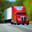

In [10]:
first_img_path = "C:/Users/Alberto/Desktop/TCD/DISSERTATION/Code and dataset/CIFAKE\\train\\FAKE\\1963 (10).jpg"
first_img = Image.open(first_img_path)
first_img

c:\Users\Alberto\anaconda3\envs\notebook\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


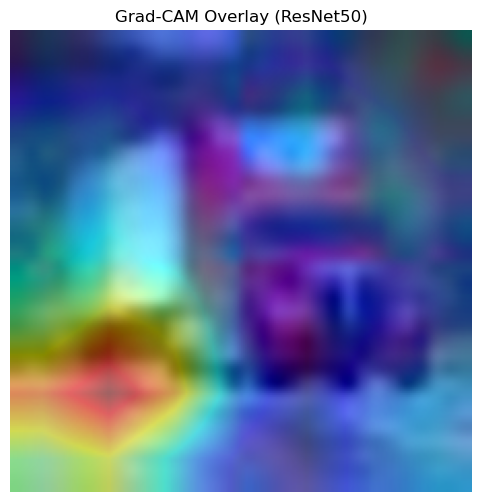

In [42]:
first_img = Image.open(first_img_path).convert("RGB")
# Generate Grad-CAM for ResNet50
resnet_attention_map = generate_gradcam_resnet(resnet_model, first_img, resnet_val_transforms, device='cuda' if torch.cuda.is_available() else 'cpu')
# Overlay Grad-CAM on the original image
resnet_overlayed_image = overlay_attention_on_image(first_img, resnet_attention_map)
# Show the Grad-CAM overlayed image
plt.figure(figsize=(8, 6))
plt.imshow(resnet_overlayed_image)
plt.axis('off')
plt.title("Grad-CAM Overlay (ResNet50)")
plt.show()

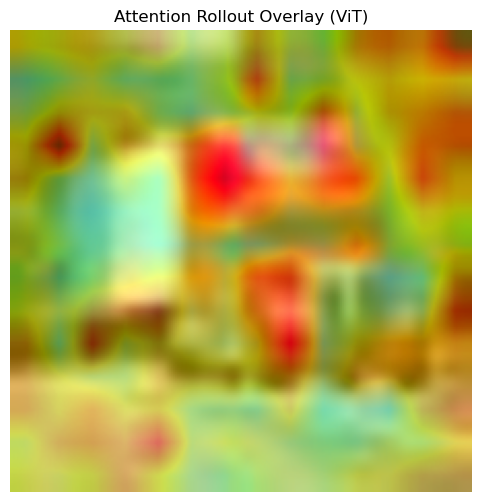

In [43]:
# FIXED: Generate attention rollout for the first image
first_img = Image.open(first_img_path).convert("RGB")

# Generate attention rollout (device handling is now inside the function)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Generate attention rollout for ViT, BEiT, and Swin models
vit_attention_map = generate_attention_rollout(vit_model, vit_processor, first_img, device=device)

# Overlay attention on the original image for ViT
vit_overlayed_image = overlay_attention_on_image(first_img, vit_attention_map)


# Show the overlayed image
plt.figure(figsize=(8, 6))
plt.imshow(vit_overlayed_image)
plt.axis('off')
plt.title("Attention Rollout Overlay (ViT)")
plt.show()

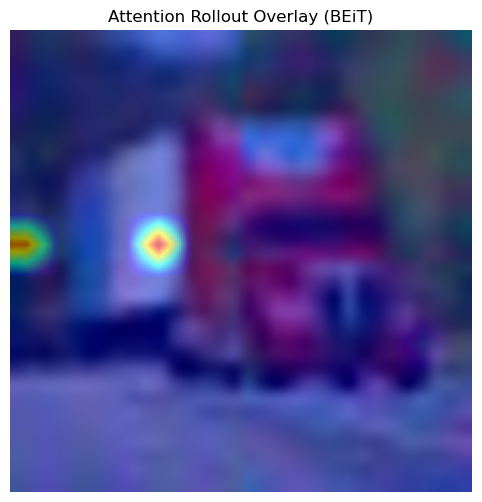

In [44]:
beit_attention_map = generate_attention_rollout(beit_model, beit_processor, first_img, device=device)
# Overlay attention on the original image for BEiT
beit_overlayed_image = overlay_attention_on_image(first_img, beit_attention_map)
# Show the overlayed image
plt.figure(figsize=(8, 6))
plt.imshow(beit_overlayed_image)
plt.axis('off')
plt.title("Attention Rollout Overlay (BEiT)")
plt.show()


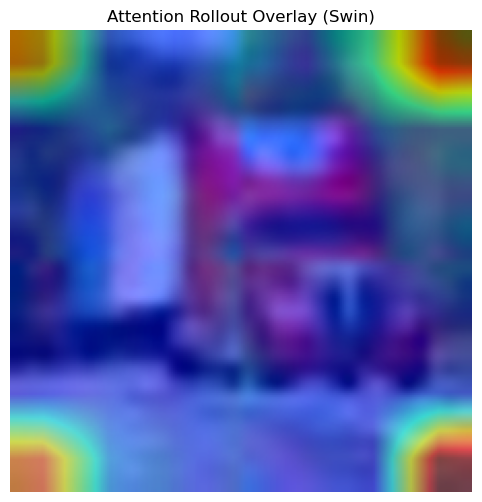

In [46]:
# Preprocess the image for Swin
inputs = swin_processor(images=first_img, return_tensors="pt")
input_tensor = inputs["pixel_values"].to(device)

# Compute Swin attention rollout using the correct function
swin_attention_map = compute_attention_rollout_swin(swin_model, input_tensor)

# Overlay attention on the original image for Swin
swin_overlayed_image = overlay_attention_on_image(first_img, swin_attention_map)

# Show the overlayed image
plt.figure(figsize=(8, 6))
plt.imshow(swin_overlayed_image)
plt.axis('off')
plt.title("Attention Rollout Overlay (Swin)")
plt.show()

In [10]:
#Import the test dataframe with predictions
test_predictions_vit = pd.read_csv("./test_predictions_vit.csv")
test_prediction_resnet50 = pd.read_csv("./test_predictions_resnet50.csv")
test_prediction_beit = pd.read_csv("./test_predictions_beit.csv")
test_prediction_swin = pd.read_csv("./test_predictions_swin.csv")

In [11]:
# Find the row in each test prediction dataframe that matches the first image path
first_img_row_vit = test_predictions_vit[test_predictions_vit['image'] == first_img_path]
first_img_row_resnet = test_prediction_resnet50[test_prediction_resnet50['image'] == first_img_path]
first_img_row_beit = test_prediction_beit[test_prediction_beit['image'] == first_img_path]
first_img_row_swin = test_prediction_swin[test_prediction_swin['image'] == first_img_path]

# Display the prediction info for the first image for each model
print("ViT prediction:")
display(first_img_row_vit[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']])

print("ResNet50 prediction:")
display(first_img_row_resnet[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']])

print("BEiT prediction:")
display(first_img_row_beit[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']])

print("Swin prediction:")
display(first_img_row_swin[['label', 'predicted_label', 'probability_fake', 'probability_real', 'confidence', 'correct_prediction']])

ViT prediction:


,label,predicted_label,probability_fake,probability_real,confidence,correct_prediction
2452,FAKE,FAKE,0.950381,0.049619,0.950381,True


ResNet50 prediction:


,label,predicted_label,probability_fake,probability_real,confidence,correct_prediction
2452,FAKE,FAKE,0.931739,0.068261,0.931739,True


BEiT prediction:


,label,predicted_label,probability_fake,probability_real,confidence,correct_prediction
2452,FAKE,FAKE,0.948807,0.051193,0.948807,True


Swin prediction:


,label,predicted_label,probability_fake,probability_real,confidence,correct_prediction
2452,FAKE,FAKE,0.973606,0.026394,0.973606,True


# Model Evaluation & Overfitting Analysis
After training the final ViT model with the best hyperparameters on the full dataset, we conduct a thorough evaluation to assess its generalization performance. While the test accuracy and F1 score are remarkably high, it is essential to ensure the model is not overfitting the training data.

To do this, we analyze various indicators including prediction confidence distributions, ROC and PR curves, and misclassification patterns. These visual diagnostics provide insights into how well the model maintains performance on unseen data and whether its predictions remain reliable across confidence levels.

## Confidence Distribution

This is not inherently a sign of overfitting, but it does suggest the model is very certain.

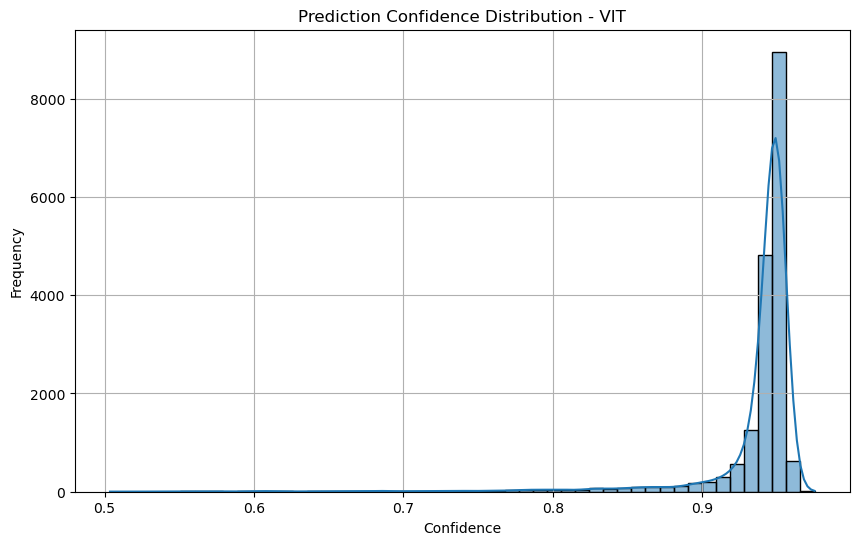

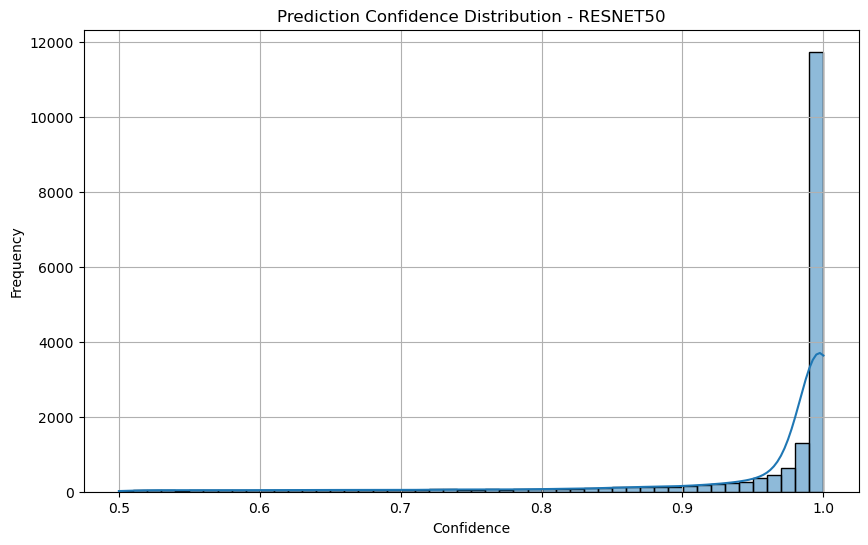

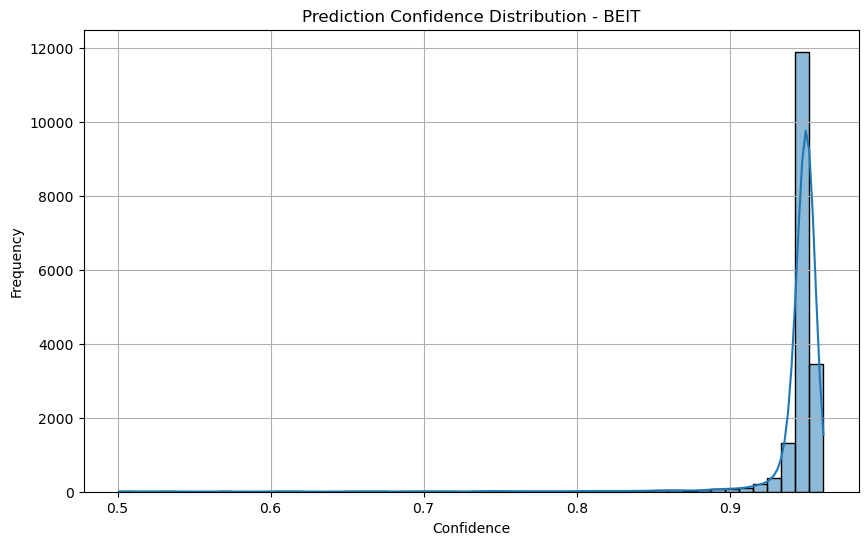

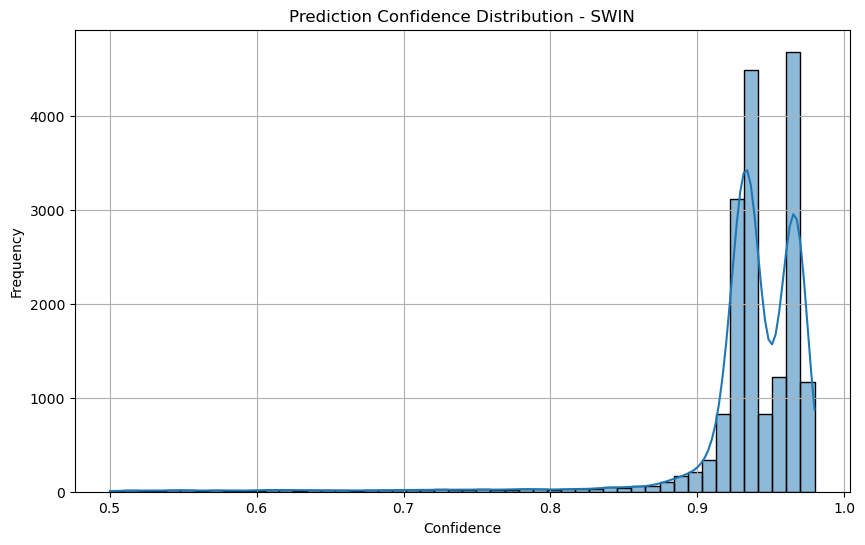

In [12]:
# Plot plots prediction confidence distribution for every test_prediction_{model_type} 
model_types = ['vit', 'resnet50', 'beit', 'swin']
dfs = {
    'vit': test_predictions_vit,
    'resnet50': test_prediction_resnet50,
    'beit': test_prediction_beit,
    'swin': test_prediction_swin
}
for model_type in model_types:
    plt.figure(figsize=(10, 6))
    sns.histplot(dfs[model_type]['confidence'], bins=50, kde=True)
    plt.title(f'Prediction Confidence Distribution - {model_type.upper()}')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

## Confusion Matrix

Balanced performance: Model performs equally well on both classes, which is rare in overfit models.

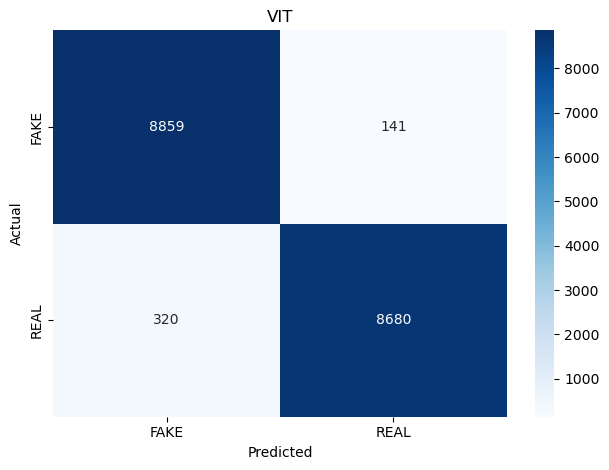

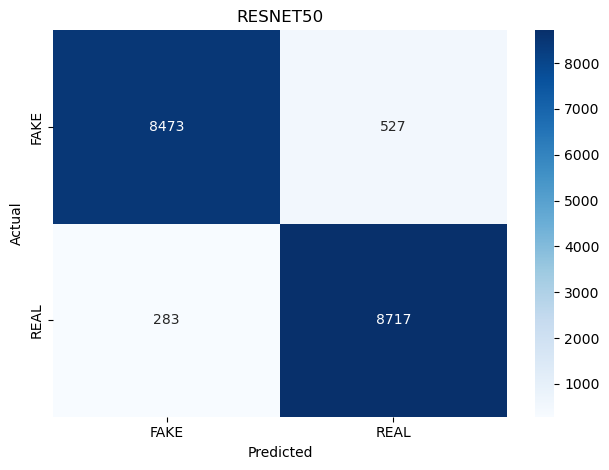

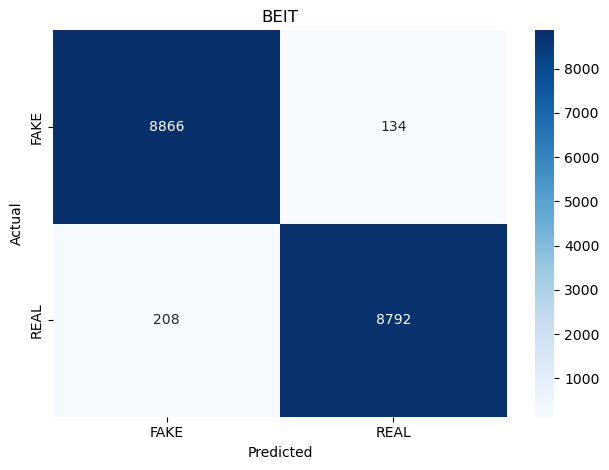

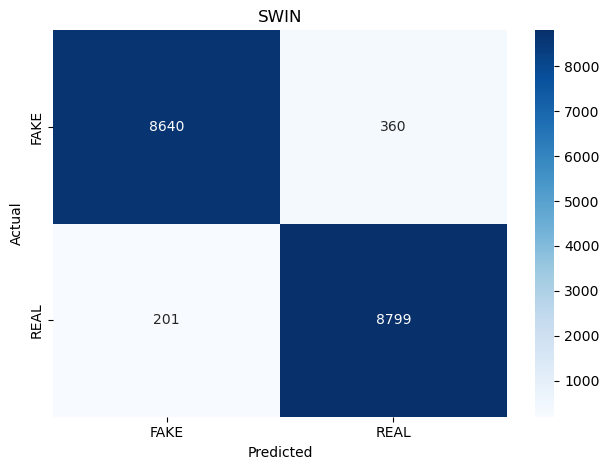

In [13]:
for model_type in model_types:
    cm = confusion_matrix(
        dfs[model_type]['label'],
        dfs[model_type]['predicted_label'],
        labels=['FAKE', 'REAL']
    )

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['FAKE', 'REAL'],
        yticklabels=['FAKE', 'REAL']
    )
    plt.title(f'{model_type.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

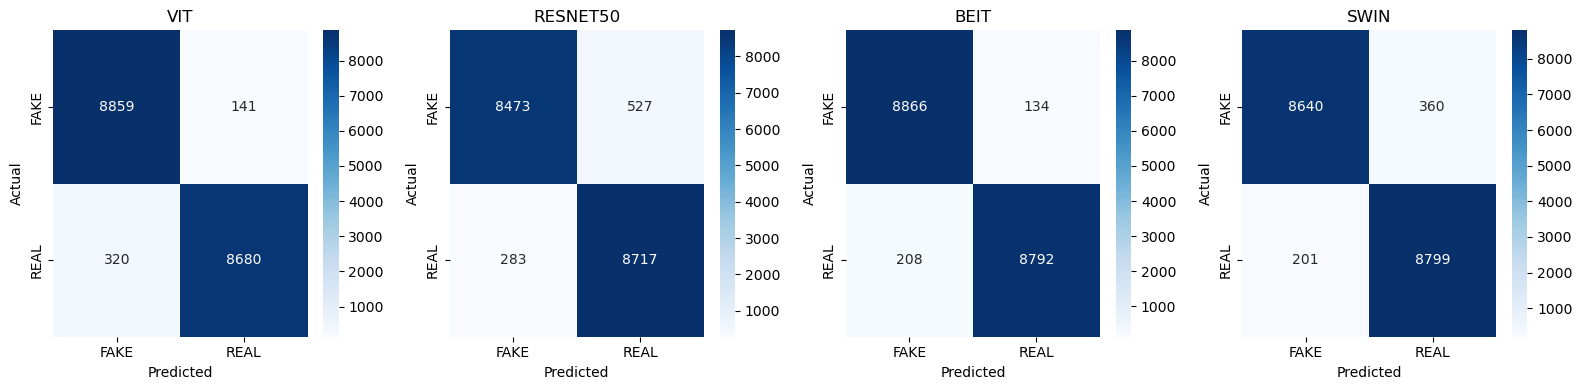

In [48]:
plt.figure(figsize=(16, 4))
for i, model_type in enumerate(model_types):
    cm = confusion_matrix(
        dfs[model_type]['label'],
        dfs[model_type]['predicted_label'],
        labels=['FAKE', 'REAL']
    )
    plt.subplot(1, 4, i + 1)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['FAKE', 'REAL'],
        yticklabels=['FAKE', 'REAL']
    )
    plt.title(f'{model_type.upper()}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [18]:
for model_type in model_types:
    print(f"\n{model_type.upper()} Model Test Results:")
    print(f"  Accuracy: {dfs[model_type]['correct_prediction'].mean():.4f}")
    print(f"  Total Predictions: {len(dfs[model_type])}")
    print(f"  Correct Predictions: {dfs[model_type]['correct_prediction'].sum()}")
    print(f"  Incorrect Predictions: {len(dfs[model_type]) - dfs[model_type]['correct_prediction'].sum()}")
    print(f"  F1 Score: {f1_score(dfs[model_type]['label'], dfs[model_type]['predicted_label'], pos_label='REAL'):.4f}")
    print(f"  Precision: {precision_score(dfs[model_type]['label'], dfs[model_type]['predicted_label'], pos_label='REAL'):.4f}")
    print(f"  Recall: {recall_score(dfs[model_type]['label'], dfs[model_type]['predicted_label'], pos_label='REAL'):.4f}")



VIT Model Test Results:
  Accuracy: 0.9744
  Total Predictions: 18000
  Correct Predictions: 17539
  Incorrect Predictions: 461
  F1 Score: 0.9741
  Precision: 0.9840
  Recall: 0.9644

RESNET50 Model Test Results:
  Accuracy: 0.9550
  Total Predictions: 18000
  Correct Predictions: 17190
  Incorrect Predictions: 810
  F1 Score: 0.9556
  Precision: 0.9430
  Recall: 0.9686

BEIT Model Test Results:
  Accuracy: 0.9810
  Total Predictions: 18000
  Correct Predictions: 17658
  Incorrect Predictions: 342
  F1 Score: 0.9809
  Precision: 0.9850
  Recall: 0.9769

SWIN Model Test Results:
  Accuracy: 0.9688
  Total Predictions: 18000
  Correct Predictions: 17439
  Incorrect Predictions: 561
  F1 Score: 0.9691
  Precision: 0.9607
  Recall: 0.9777


### ROC and Precision-Recall Curve Evaluation

This section visualizes the performance of the binary classifier using two commonly adopted evaluation tools:


#### **Receiver Operating Characteristic (ROC) Curve**
The ROC curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings. It helps assess the model’s ability to distinguish between the two classes (`REAL` vs `FAKE`), regardless of classification threshold.

- **AUC (Area Under the Curve)** is a scalar metric ranging from 0.5 (no discriminative power) to 1.0 (perfect classification).
- A model with an AUC close to 1 indicates strong separability between real and AI-generated images.
- The red dashed line represents a random classifier (baseline).


#### **Precision-Recall (PR) Curve**
The Precision-Recall curve is particularly informative in the context of **imbalanced classes** or **low error tolerance**.

- **Precision** measures how many predicted REAL images are truly REAL.
- **Recall** measures how many actual REAL images are correctly identified.
- **Average Precision (AP)** summarizes the area under the PR curve and serves as a threshold-independent performance metric.

These plots provide visual and quantitative insights into the classifier’s discriminative ability and are crucial for validating model robustness beyond accuracy and F1 score.


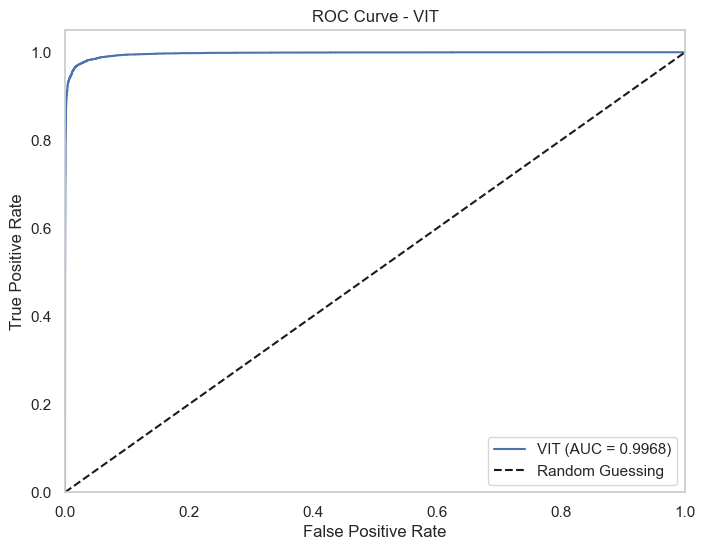

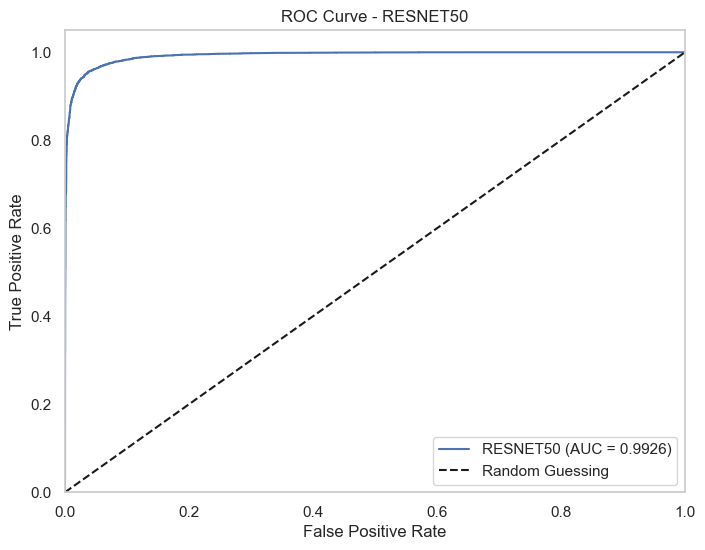

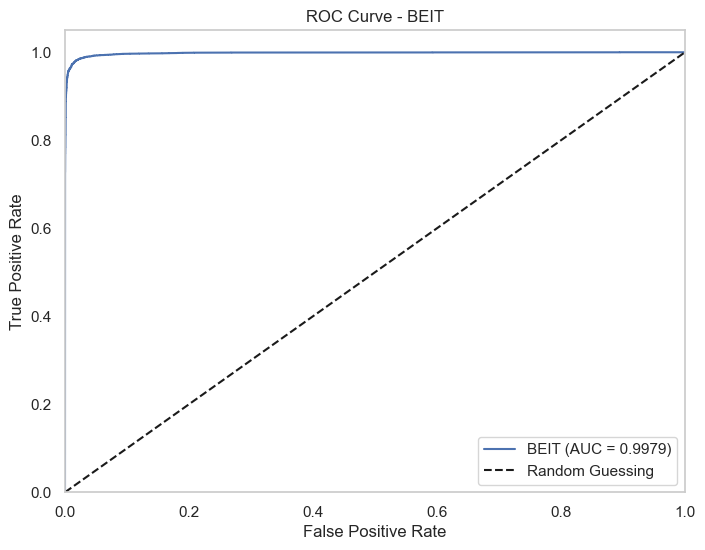

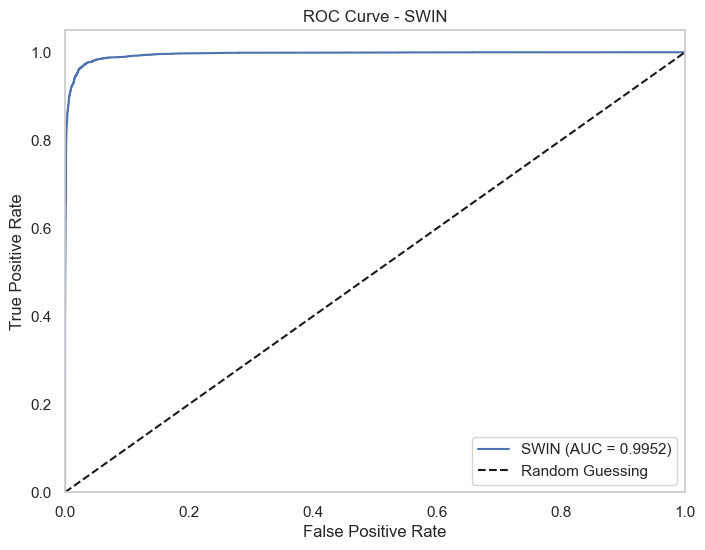

In [30]:
for model_type in model_types:
    df = dfs[model_type]
    y_true = df['label'].apply(lambda x: 1 if x == 'REAL' else 0)
    y_scores = df['probability_real']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_type.upper()} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_type.upper()}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

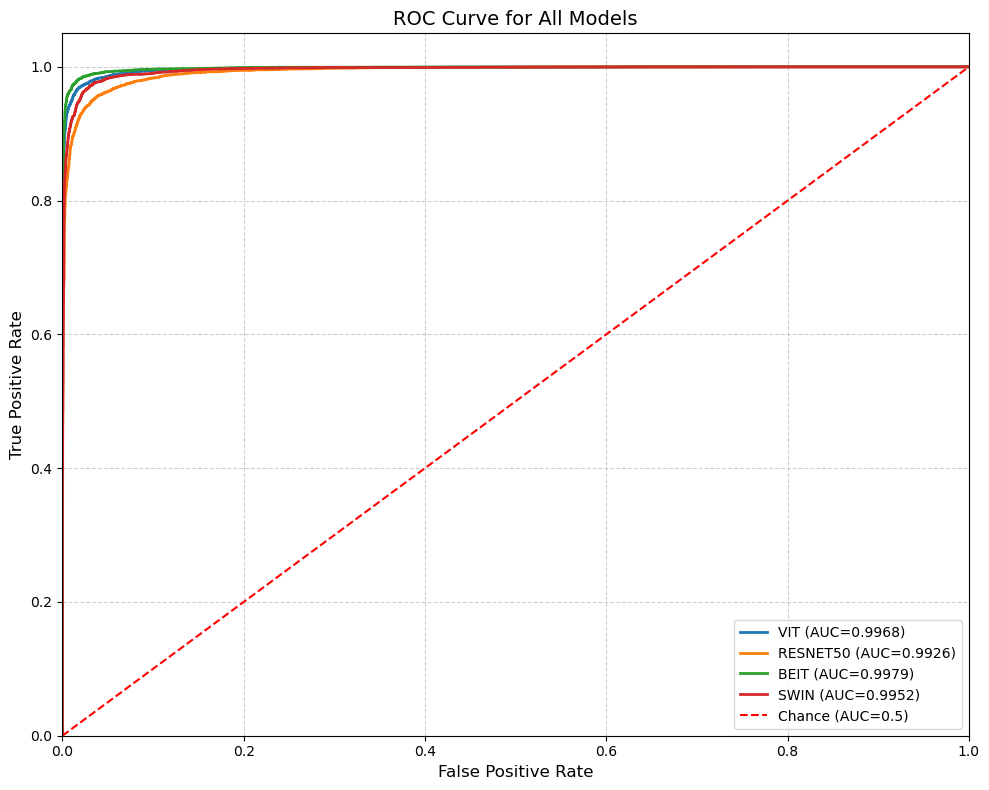

In [23]:
plt.figure(figsize=(10, 8))
for model_type in model_types:
    df = dfs[model_type]
    y_true = df['label'].apply(lambda x: 1 if x == 'REAL' else 0)
    y_scores = df['probability_real']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"{model_type.upper()} (AUC={roc_auc:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance (AUC=0.5)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for All Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

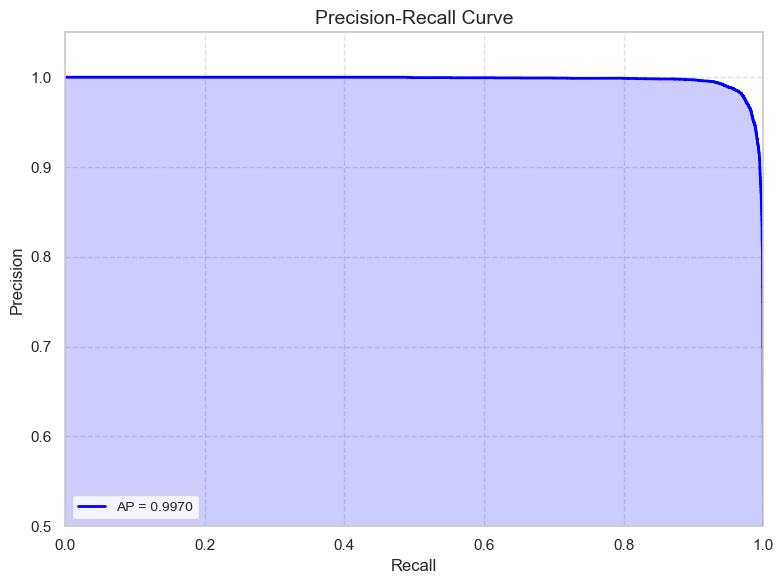

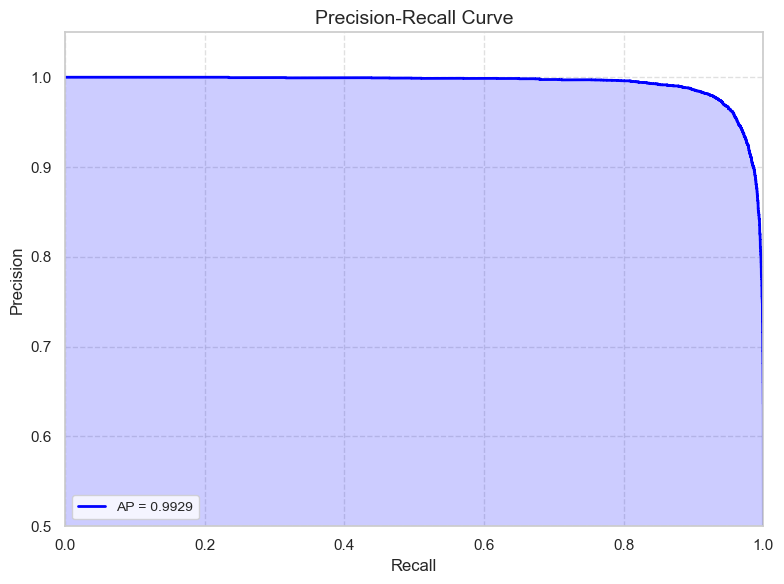

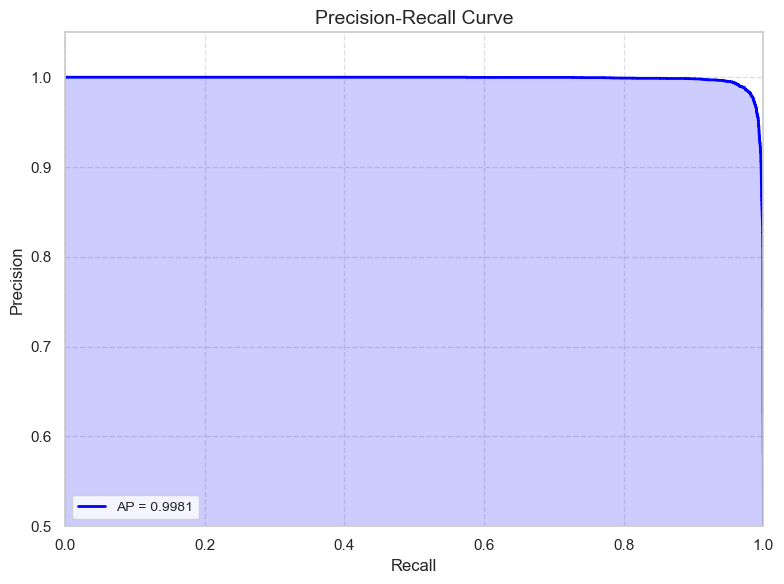

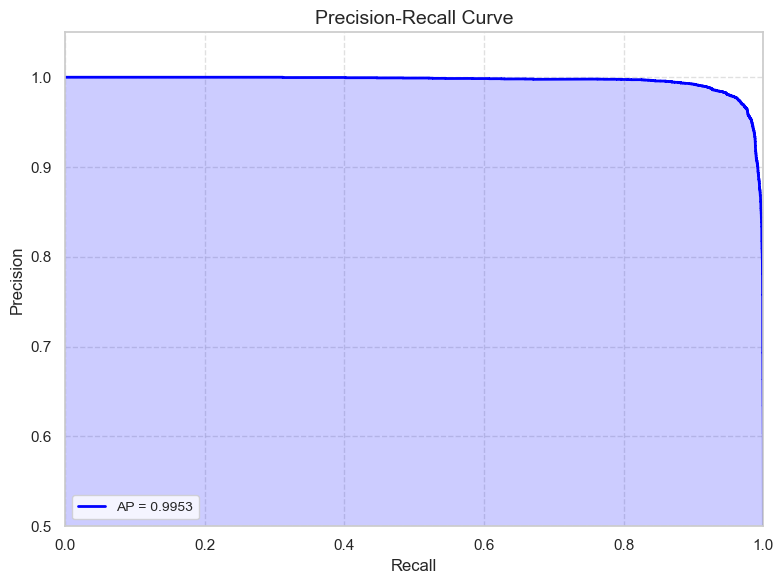

In [34]:
for model_type in model_types:
    df = dfs[model_type]
    y_true = df['label'].apply(lambda x: 1 if x == 'REAL' else 0)
    y_scores = df['probability_real']
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', linewidth=2, label=f'AP = {ap:.4f}')
    plt.fill_between(recall, precision, alpha=0.2, color='blue')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.5, 1.05])
    plt.tight_layout()
    plt.show()